Problem statement : Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. As a data scientist in the Data Science team of Ad ease we are trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients.

To optimize the ad placement for clients on wikipedia pages, we need to understand how different languages/ different regions are performing. Each language in the dataset will be treated as a seperate time series and this will help us optimiize the ad placements. 

Facebook prophet will be used for forecasting what the page views are going to looks like for different regions in future. This will help us in optimum add placements.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [2]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
adease = pd.read_csv('C:/DSML/Case study/AdEase/train_1.csv')

# Importing the dataset and doing usual exploratory analysis steps like checking the structure & characteristics of the dataset

In [4]:
adease.shape

(145063, 551)

In [5]:
adease.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [6]:
adease.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

In [7]:
adease.dtypes

Page           object
2015-07-01    float64
2015-07-02    float64
2015-07-03    float64
2015-07-04    float64
               ...   
2016-12-27    float64
2016-12-28    float64
2016-12-29    float64
2016-12-30    float64
2016-12-31    float64
Length: 551, dtype: object

# Checking null values and understanding their reason

In [8]:
adease.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

# Exploratory Data Analysis

# Separating the data

In [9]:
adease[['0','access']] = adease.Page.str.split("wikipedia.org",expand=True)

In [10]:
adease['language'] = adease['0'].str[-3:-1]

In [11]:
adease['specific_name'] = adease['0'].str[:-4]

In [12]:
adease['access'] = adease.access.str[1:]

In [13]:
adease[['access_type','access_origin']] = adease.access.str.split("_",expand=True)

In [14]:
adease.drop(['0','access','Page'],axis=1,inplace=True)

In [15]:
adease

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  \
0             18.0        11.0         5.0        13.0        14.0   
1             11.0        14.0        15.0        18.0        11.0   
2              1.0         0.0         1.0         1.0         0.0   
3             35.0        13.0        10.0        94.0         4.0   
4              NaN         NaN         NaN         NaN         NaN   
...            ...         ...         ...         ...         ...   
145058         NaN         NaN         NaN         NaN         NaN   
145059         NaN         NaN         NaN         NaN         NaN   
145060         NaN         NaN         NaN         NaN         NaN   
145061         NaN         NaN         NaN         NaN         NaN   
145062         NaN         NaN         NaN         NaN         NaN   

        2015-07-06  2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  \
0              9.0         9.0        22.0        26.0        24.0  ...   
1             13.0        22.0        11.0        10.0         4.0  ...   
2              4.0         0.0         3.0         4.0         4.0  ...   
3             26.0        14.0         9.0        11.0        16.0  ...   
4              NaN         NaN         NaN         NaN         NaN  ...   
...            ...         ...         ...         ...         ...  ...   
145058         NaN         NaN         NaN         NaN         NaN  ...   
145059         NaN         NaN         NaN         NaN         NaN  ...   
145060         NaN         NaN         NaN         NaN         NaN  ...   
145061         NaN         NaN         NaN         NaN         NaN  ...   
145062         NaN         NaN         NaN         NaN         NaN  ...   

        2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  \
0             14.0        20.0        22.0        19.0        18.0   
1              9.0        30.0        52.0        45.0        26.0   
2              4.0         4.0         6.0         3.0         4.0   
3             16.0        11.0        17.0        19.0        10.0   
4              3.0        11.0        27.0        13.0        36.0   
...            ...         ...         ...         ...         ...   
145058        13.0        12.0        13.0         3.0         5.0   
145059         NaN         NaN         NaN         NaN         NaN   
145060         NaN         NaN         NaN         NaN         NaN   
145061         NaN         NaN         NaN         NaN         NaN   
145062         NaN         NaN         NaN         NaN         NaN   

        2016-12-31  language  \
0             20.0        zh   
1             20.0        zh   
2             17.0        zh   
3             11.0        zh   
4             10.0        zh   
...            ...       ...   
145058        10.0        es   
145059         NaN        es   
145060         NaN        es   
145061         NaN        es   
145062         NaN        es   

                                            specific_name  access_type  \
0                                                    2NE1   all-access   
1                                                     2PM   all-access   
2                                                      3C   all-access   
3                                                 4minute   all-access   
4                                        52_Hz_I_Love_You   all-access   
...                                                   ...          ...   
145058                    Underworld_(serie_de_películas)   all-access   
145059                      Resident_Evil:_Capítulo_Final   all-access   
145060                              Enamorándome_de_Ramón   all-access   
145061                             Hasta_el_último_hombre   all-access   
145062  Francisco_el_matemático_(serie_de_televisión_d...   all-access   

        access_origin  
0              spider  
1              spider  
2              spider  
3              spider  
4              spider  
...    

# Analyzing and visualizing the data

# Visual analysis

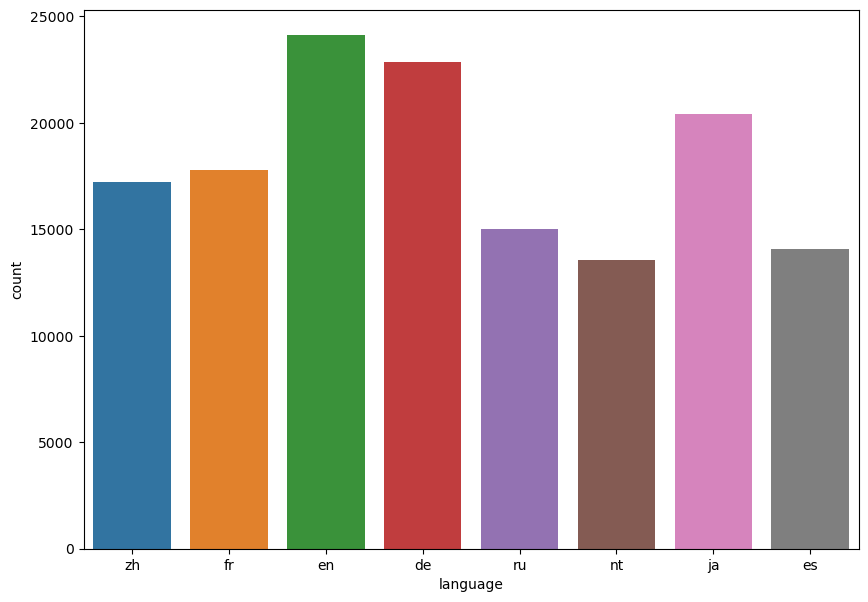

In [16]:
countplt, ax = plt.subplots(figsize = (10,7))
ax = sns.countplot(x = 'language',data = adease)

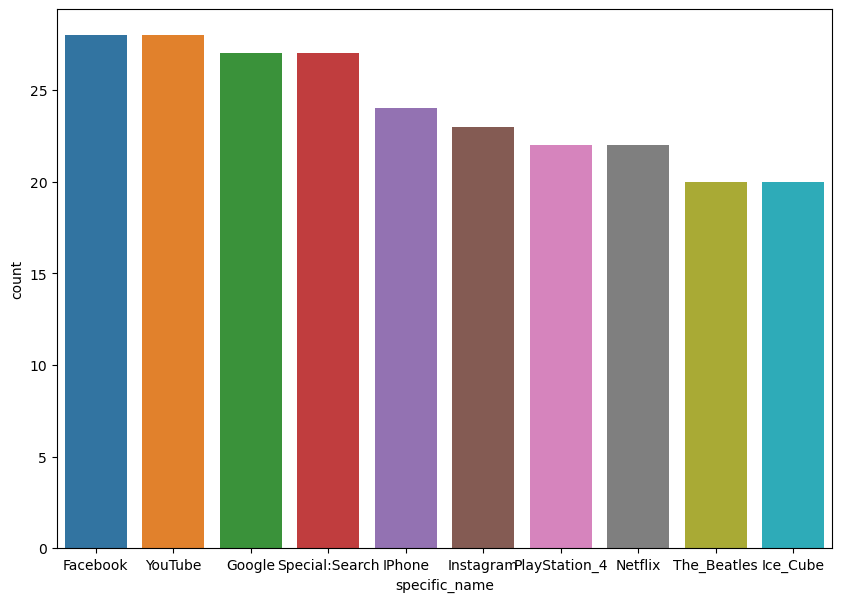

In [17]:
countplt, ax = plt.subplots(figsize = (10,7))
ax = sns.countplot(x = 'specific_name',data = adease,order=adease.value_counts(adease['specific_name']).iloc[:10].index)

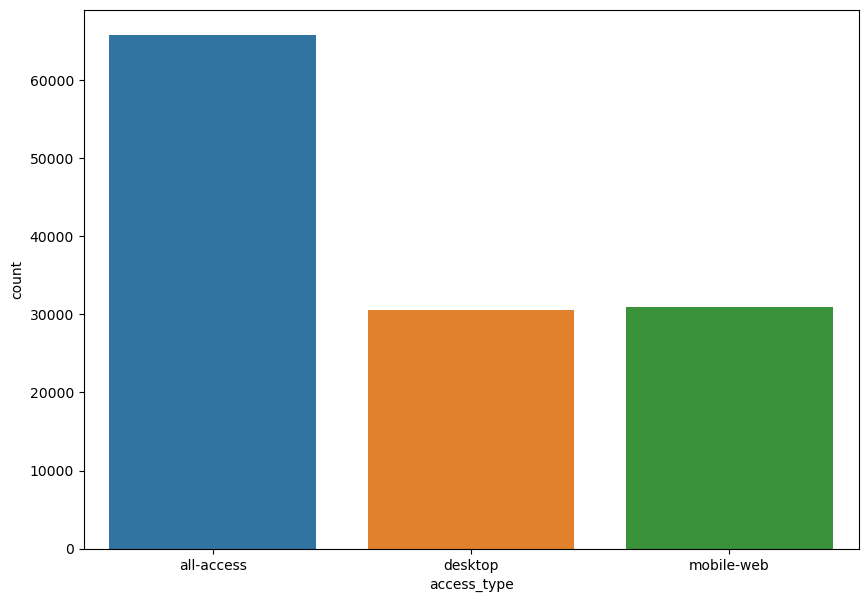

In [18]:
countplt, ax = plt.subplots(figsize = (10,7))
ax = sns.countplot(x = 'access_type',data = adease)

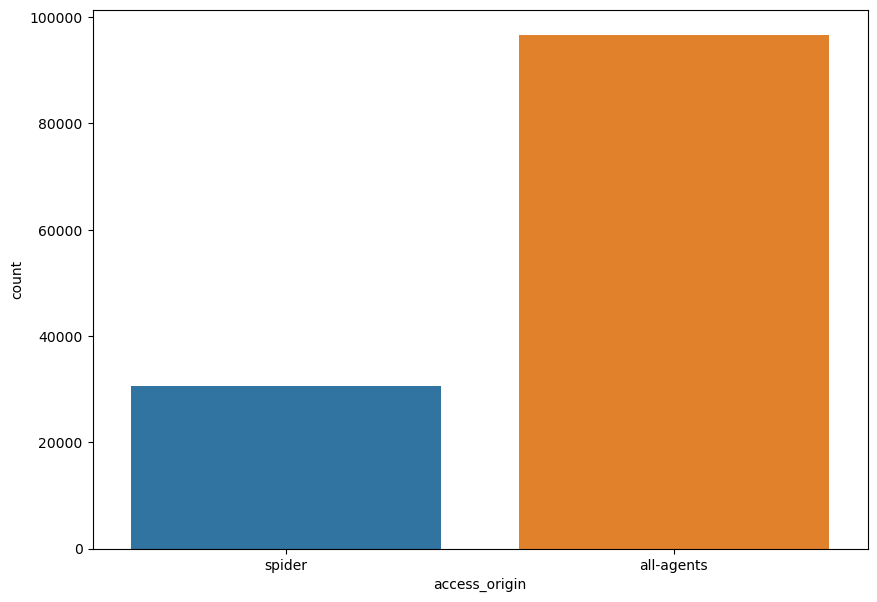

In [19]:
countplt, ax = plt.subplots(figsize = (10,7))
ax = sns.countplot(x = 'access_origin',data = adease)

# Converting and formatting the data

In [20]:
adease1 = adease.groupby('language').sum()

In [21]:
adease1

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  \
language                                                               
de        13299837.0  13142154.0  12615201.0  11573244.0  13470112.0   
en        84712190.0  84438545.0  80167728.0  83463204.0  86198637.0   
es        15278553.0  14601013.0  13427632.0  12606538.0  13710356.0   
fr         8458638.0   8512952.0   8186030.0   8749842.0   8590493.0   
ja        11863200.0  13620792.0  12305383.0  15456239.0  14827204.0   
nt         1451216.0   1499552.0   1415102.0   1207208.0   1318756.0   
ru         9463854.0   9627643.0   8923463.0   8393214.0   8938528.0   
zh         4144988.0   4151189.0   4123659.0   4163448.0   4441286.0   

          2015-07-06  2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  \
language                                                              ...   
de        14814542.0  14347745.0  14611691.0  14019764.0  13074713.0  ...   
en        92809436.0  87838054.0  82880196.0  84798911.0  84319456.0  ...   
es        15625554.0  15230654.0  14781870.0  14502906.0  13184481.0  ...   
fr         8949799.0   8650800.0   8491533.0   8403646.0   7930703.0  ...   
ja        12920547.0  12568828.0  12492787.0  12178258.0  12652904.0  ...   
nt         1529170.0   1643691.0   1662875.0   1488498.0   1499469.0  ...   
ru         9628896.0   9408180.0   9364117.0   9592309.0  10984872.0  ...   
zh         4464290.0   4459421.0   4575842.0   4547843.0   4727889.0  ...   

           2016-12-22   2016-12-23   2016-12-24   2016-12-25   2016-12-26  \
language                                                                    
de         15484102.0   15687270.0   15155751.0   23894845.0   22491321.0   
en        120491573.0  112905341.0  119860920.0  123926291.0  139112120.0   
es         13837820.0   13155676.0   12385052.0   12713363.0   16819231.0   
fr         11606988.0   11383657.0   11005480.0   11867509.0   16678423.0   
ja         13793066.0   19777366.0   17501297.0   16720214.0   15918093.0   
nt          2234827.0    2818238.0    2387539.0    2801851.0    2845971.0   
ru         13465000.0   13292086.0   13133353.0   16839517.0   16717095.0   
zh          5946850.0    5865102.0    6215165.0    6569812.0    6485813.0   

           2016-12-27   2016-12-28   2016-12-29   2016-12-30   2016-12-31  
language                                                                   
de         20229121.0   19245058.0   18545710.0   17717316.0   16665282.0  
en        145628731.0  141278366.0  150557534.0  125404585.0  123623809.0  
es         15945353.0   16577375.0   15647135.0   11560095.0   11077924.0  
fr         15281470.0   13781521.0   13399796.0   12471074.0   11504691.0  
ja         16123301.0   16150715.0   17682688.0   19450687.0   24460799.0  
nt          2521523.0    3236182.0    2532184.0    2826586.0    2467691.0  
ru         15040168.0   14000319.0   13478977.0   12066750.0   13223033.0  
zh          6478442.0    6513400.0    6042545.0    6111203.0    6298565.0  

[8 rows x 550 columns]

In [22]:
adease1 = adease1.transpose()

In [23]:
adease1

language            de           en          es          fr          ja  \
2015-07-01  13299837.0   84712190.0  15278553.0   8458638.0  11863200.0   
2015-07-02  13142154.0   84438545.0  14601013.0   8512952.0  13620792.0   
2015-07-03  12615201.0   80167728.0  13427632.0   8186030.0  12305383.0   
2015-07-04  11573244.0   83463204.0  12606538.0   8749842.0  15456239.0   
2015-07-05  13470112.0   86198637.0  13710356.0   8590493.0  14827204.0   
...                ...          ...         ...         ...         ...   
2016-12-27  20229121.0  145628731.0  15945353.0  15281470.0  16123301.0   
2016-12-28  19245058.0  141278366.0  16577375.0  13781521.0  16150715.0   
2016-12-29  18545710.0  150557534.0  15647135.0  13399796.0  17682688.0   
2016-12-30  17717316.0  125404585.0  11560095.0  12471074.0  19450687.0   
2016-12-31  16665282.0  123623809.0  11077924.0  11504691.0  24460799.0   

language           nt          ru         zh  
2015-07-01  1451216.0   9463854.0  4144988.0  
2015-07-02  1499552.0   9627643.0  4151189.0  
2015-07-03  1415102.0   8923463.0  4123659.0  
2015-07-04  1207208.0   8393214.0  4163448.0  
2015-07-05  1318756.0   8938528.0  4441286.0  
...               ...         ...        ...  
2016-12-27  2521523.0  15040168.0  6478442.0  
2016-12-28  3236182.0  14000319.0  6513400.0  
2016-12-29  2532184.0  13478977.0  6042545.0  
2016-12-30  2826586.0  12066750.0  6111203.0  
2016-12-31  2467691.0  13223033.0  6298565.0  

[550 rows x 8 columns]

In [24]:
adease1 = adease1.rename_axis('DATE', axis=1)

In [25]:
adease1

DATE                de           en          es          fr          ja  \
2015-07-01  13299837.0   84712190.0  15278553.0   8458638.0  11863200.0   
2015-07-02  13142154.0   84438545.0  14601013.0   8512952.0  13620792.0   
2015-07-03  12615201.0   80167728.0  13427632.0   8186030.0  12305383.0   
2015-07-04  11573244.0   83463204.0  12606538.0   8749842.0  15456239.0   
2015-07-05  13470112.0   86198637.0  13710356.0   8590493.0  14827204.0   
...                ...          ...         ...         ...         ...   
2016-12-27  20229121.0  145628731.0  15945353.0  15281470.0  16123301.0   
2016-12-28  19245058.0  141278366.0  16577375.0  13781521.0  16150715.0   
2016-12-29  18545710.0  150557534.0  15647135.0  13399796.0  17682688.0   
2016-12-30  17717316.0  125404585.0  11560095.0  12471074.0  19450687.0   
2016-12-31  16665282.0  123623809.0  11077924.0  11504691.0  24460799.0   

DATE               nt          ru         zh  
2015-07-01  1451216.0   9463854.0  4144988.0  
2015-07-02  1499552.0   9627643.0  4151189.0  
2015-07-03  1415102.0   8923463.0  4123659.0  
2015-07-04  1207208.0   8393214.0  4163448.0  
2015-07-05  1318756.0   8938528.0  4441286.0  
...               ...         ...        ...  
2016-12-27  2521523.0  15040168.0  6478442.0  
2016-12-28  3236182.0  14000319.0  6513400.0  
2016-12-29  2532184.0  13478977.0  6042545.0  
2016-12-30  2826586.0  12066750.0  6111203.0  
2016-12-31  2467691.0  13223033.0  6298565.0  

[550 rows x 8 columns]

# Checking stationarity 

# Dickey fuller test

In [26]:
import statsmodels.api as sm

def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1]
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')

In [27]:
adf_test(adease1.en)

Sequence is not stationary


In [28]:
adf_test(adease1.de)

Sequence is not stationary


In [29]:
adf_test(adease1.es)

Sequence is stationary


In [30]:
adf_test(adease1.fr)

Sequence is not stationary


In [31]:
adf_test(adease1.ja)

Sequence is not stationary


In [32]:
adf_test(adease1.nt)

Sequence is stationary


In [33]:
adf_test(adease1.ru)

Sequence is stationary


In [34]:
adf_test(adease1.zh)

Sequence is not stationary


# Decomposition

In [35]:
def decomposition(language):
    language.plot()
    series = language
    model = sm.tsa.seasonal_decompose(x=series, model='additive',period=90)
    plt.rcParams['figure.figsize'] = (20, 10)
    model.plot()

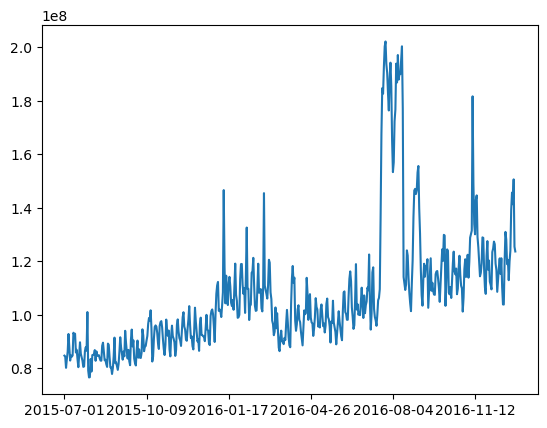

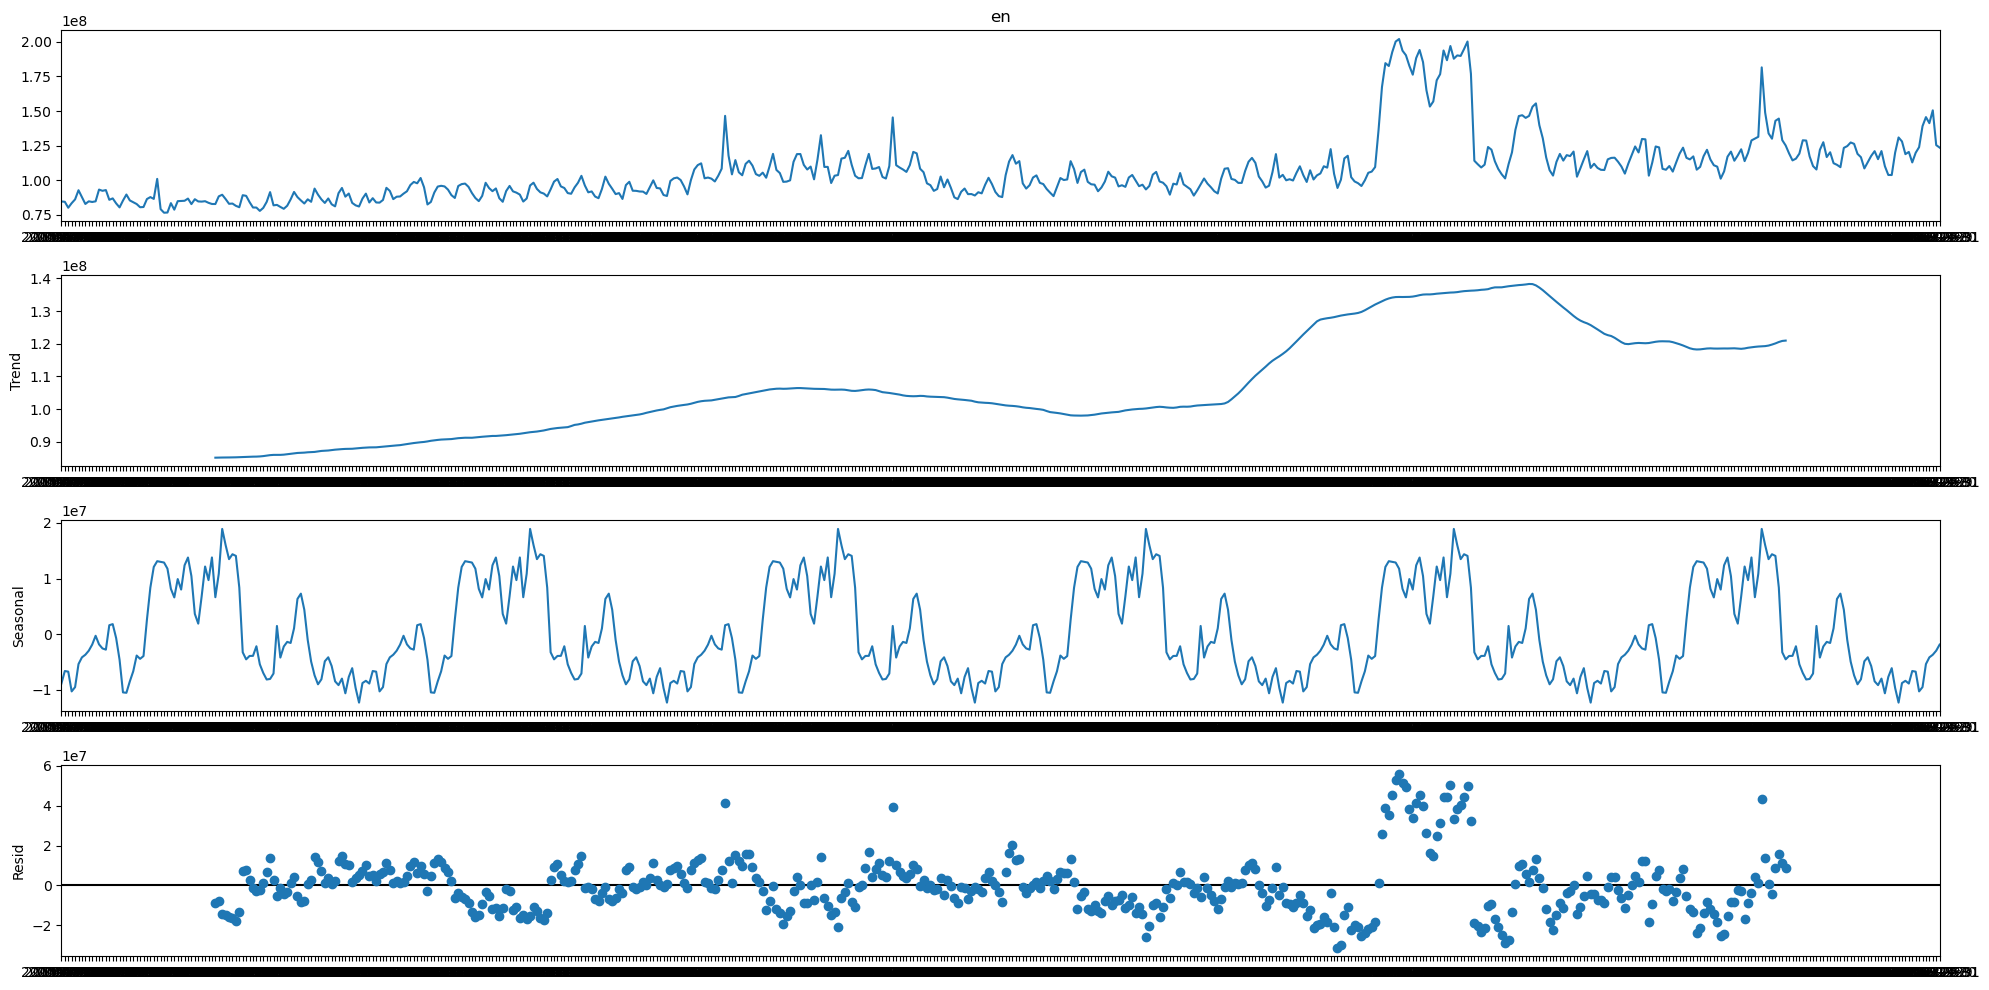

In [36]:
decomposition(adease1.en)

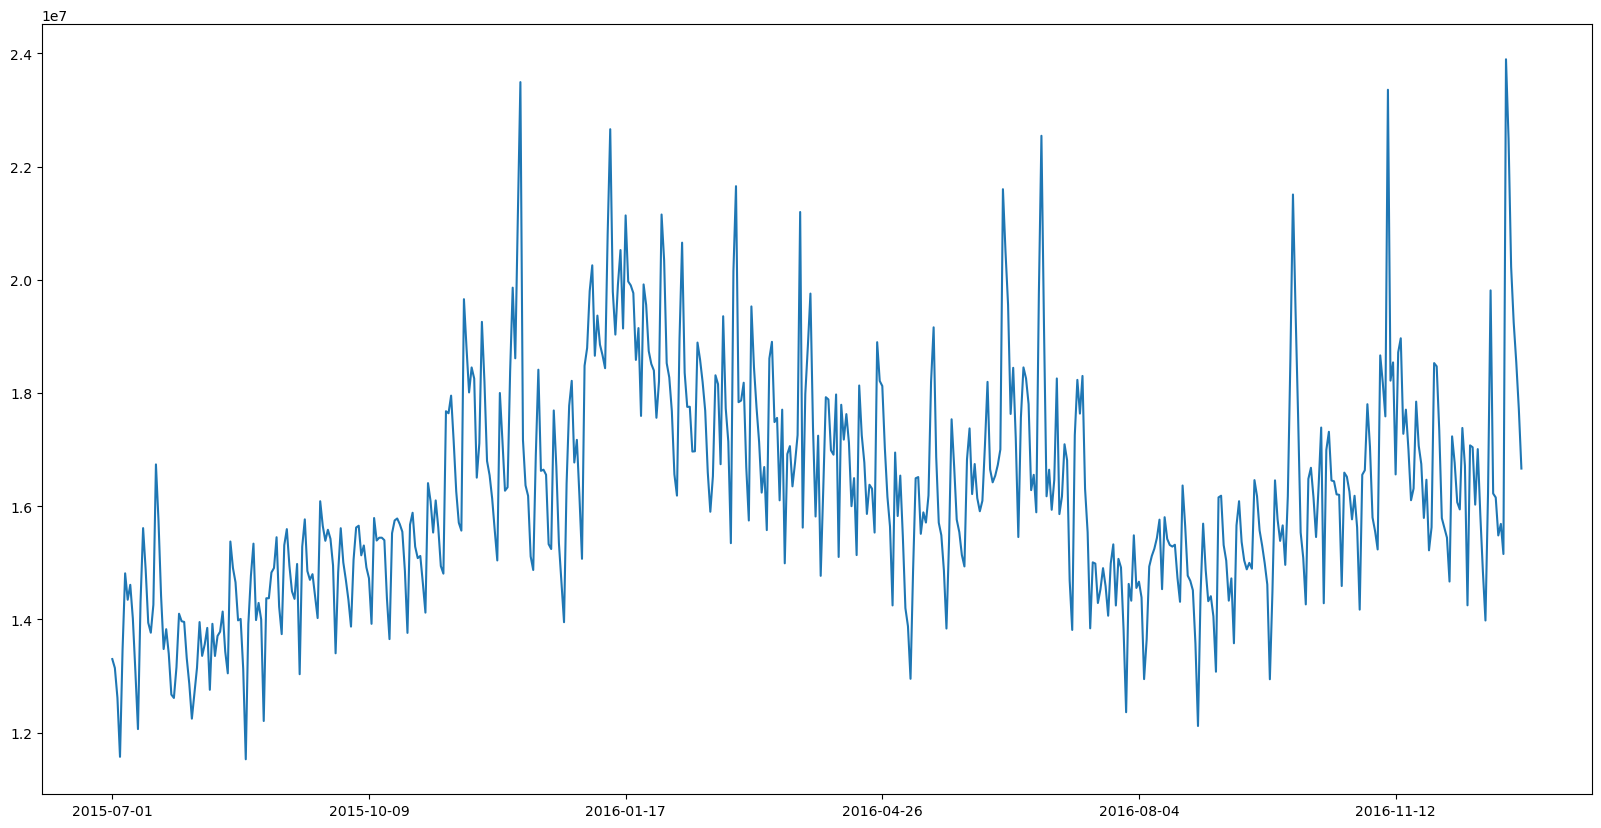

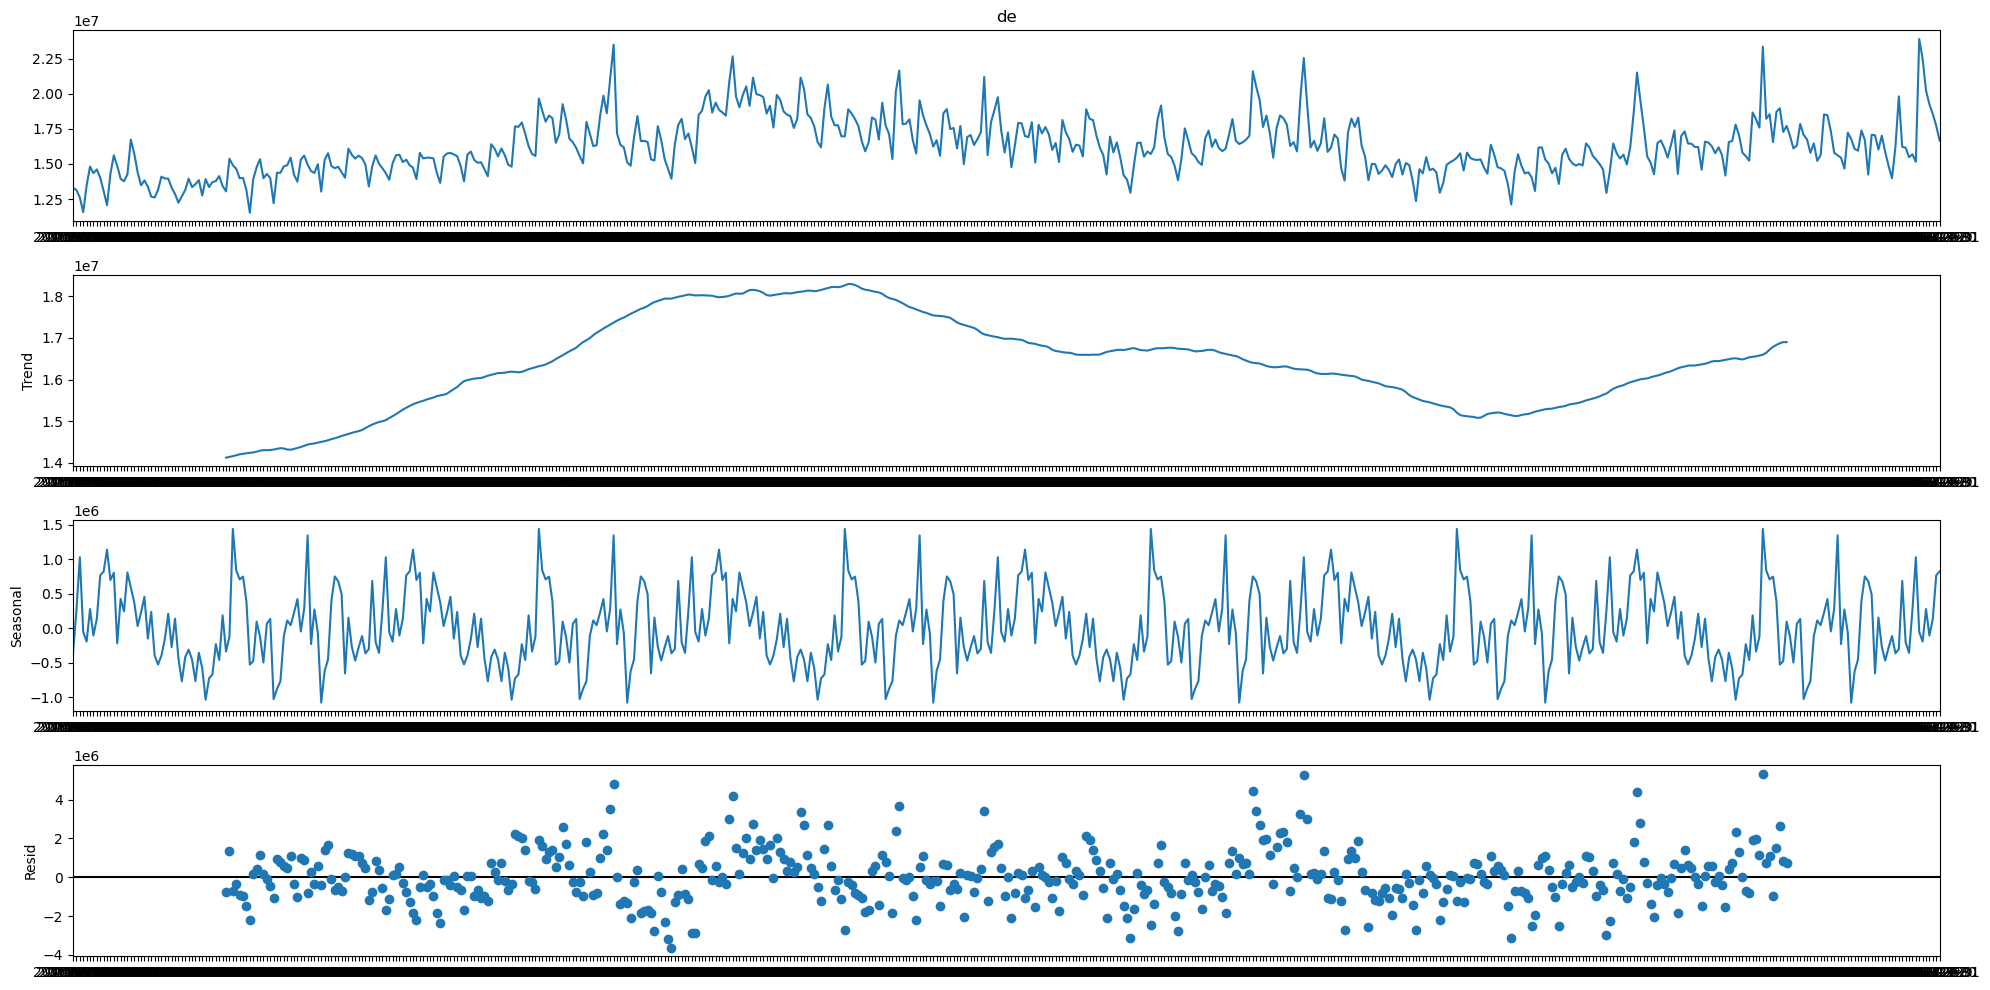

In [37]:
decomposition(adease1.de)

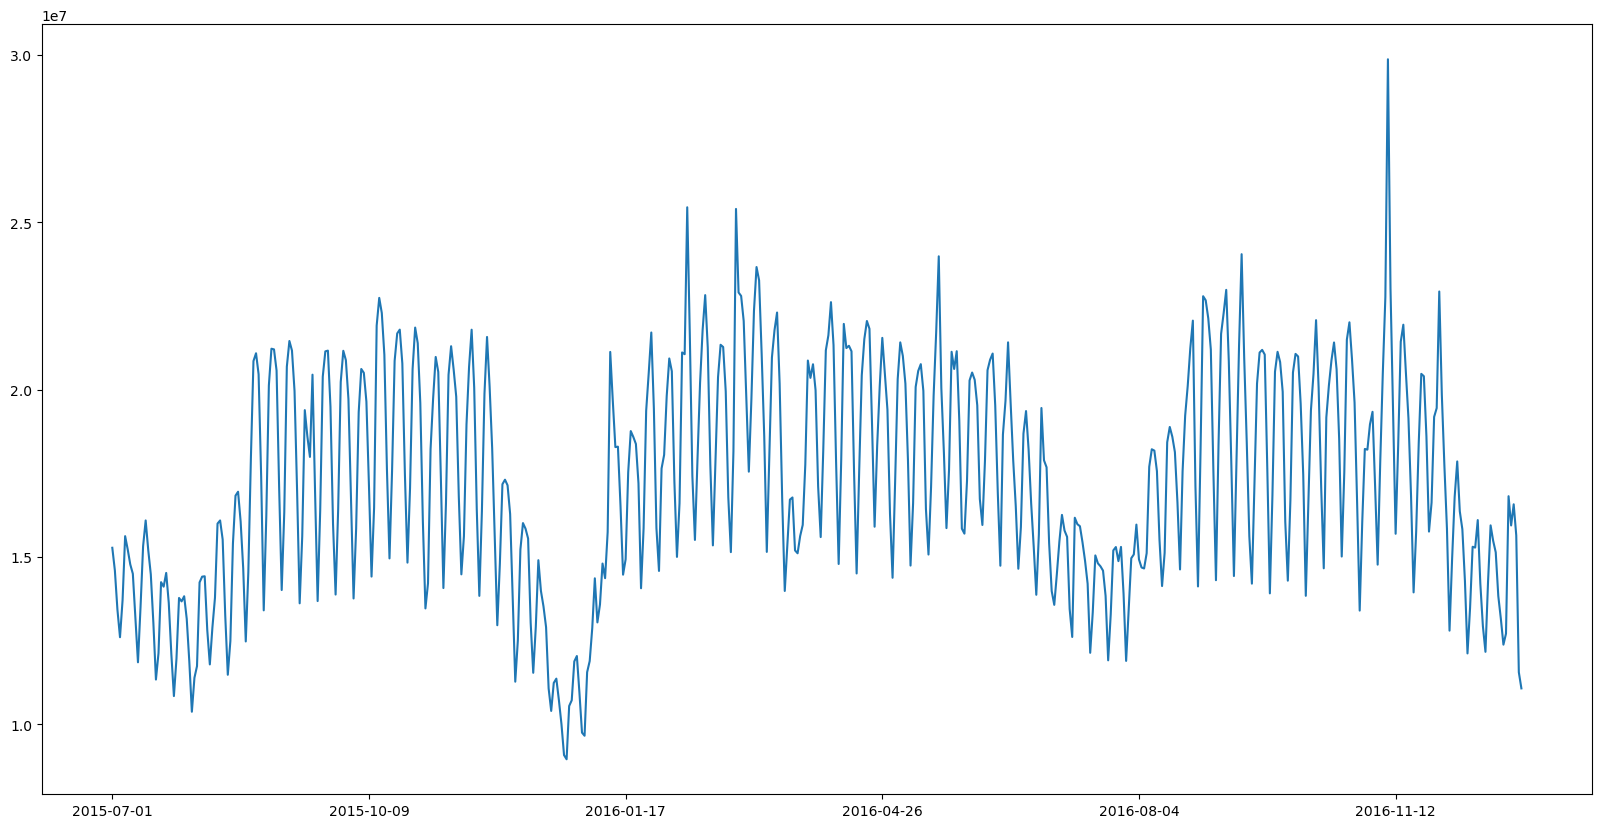

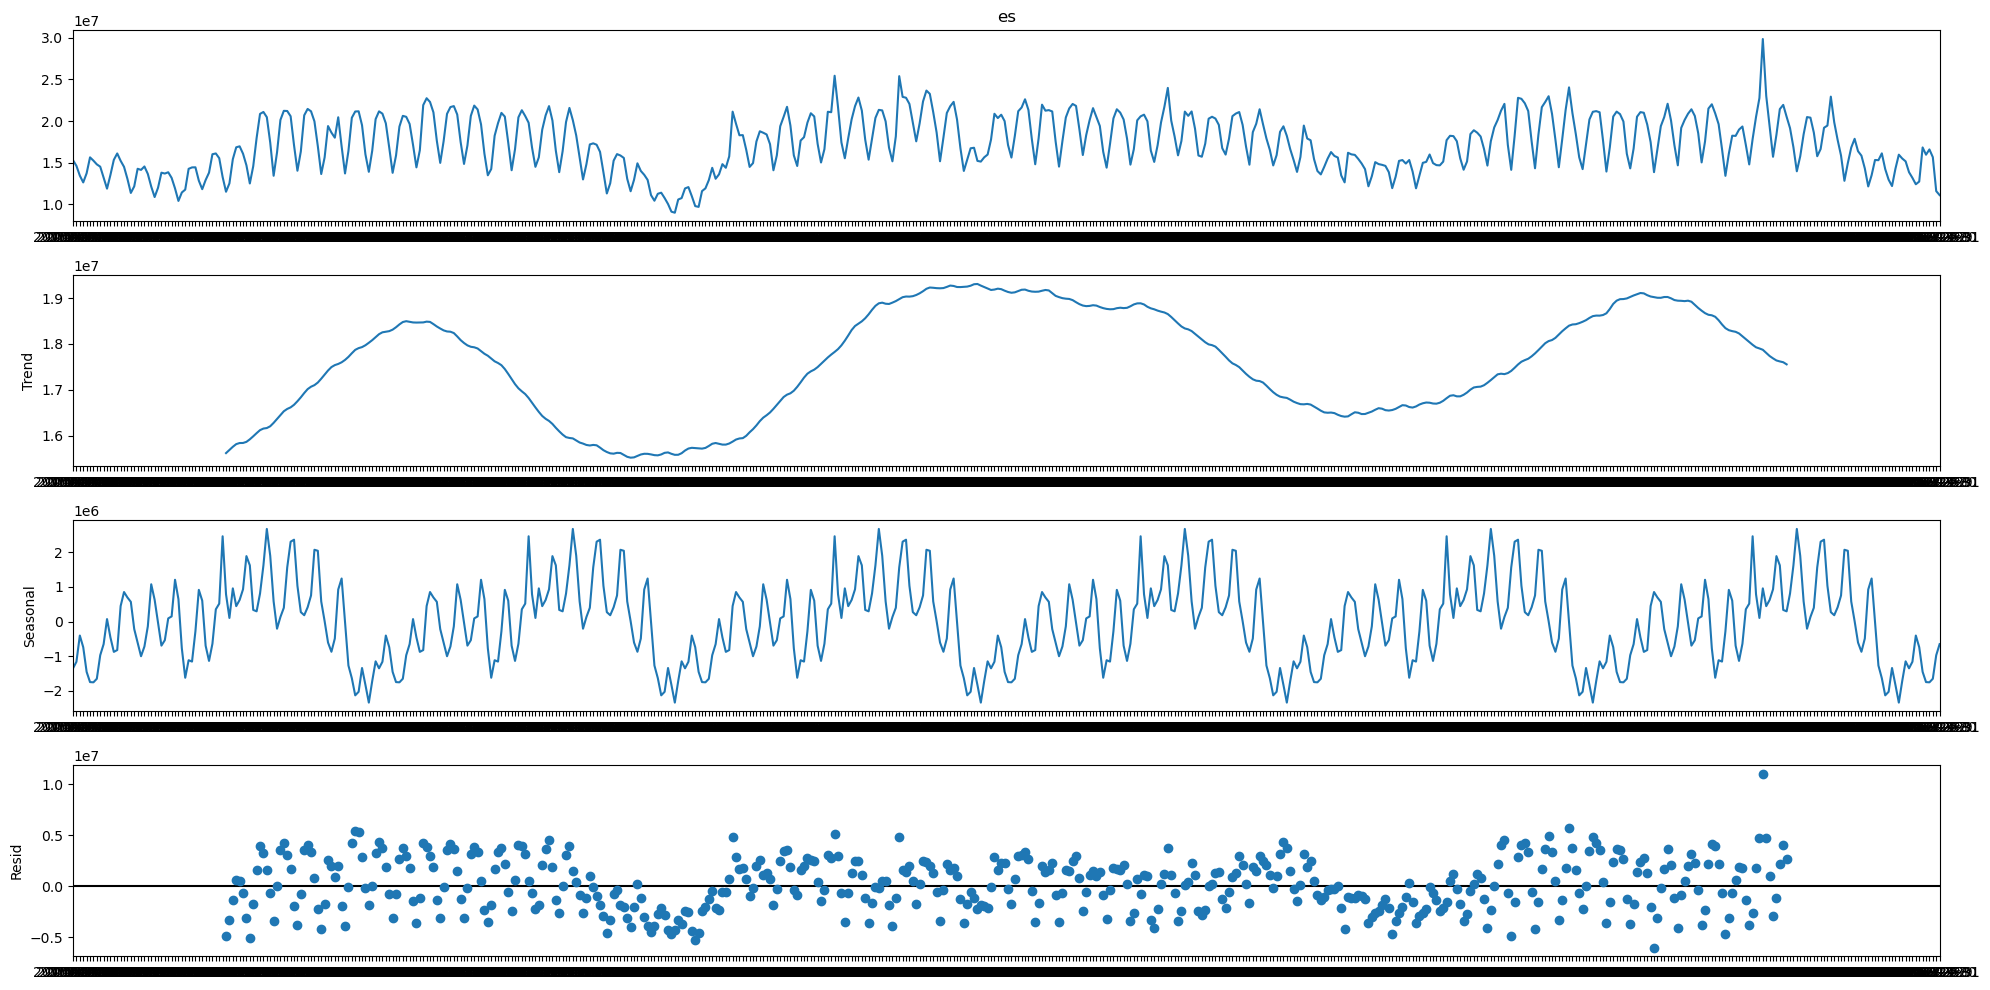

In [38]:
decomposition(adease1.es)

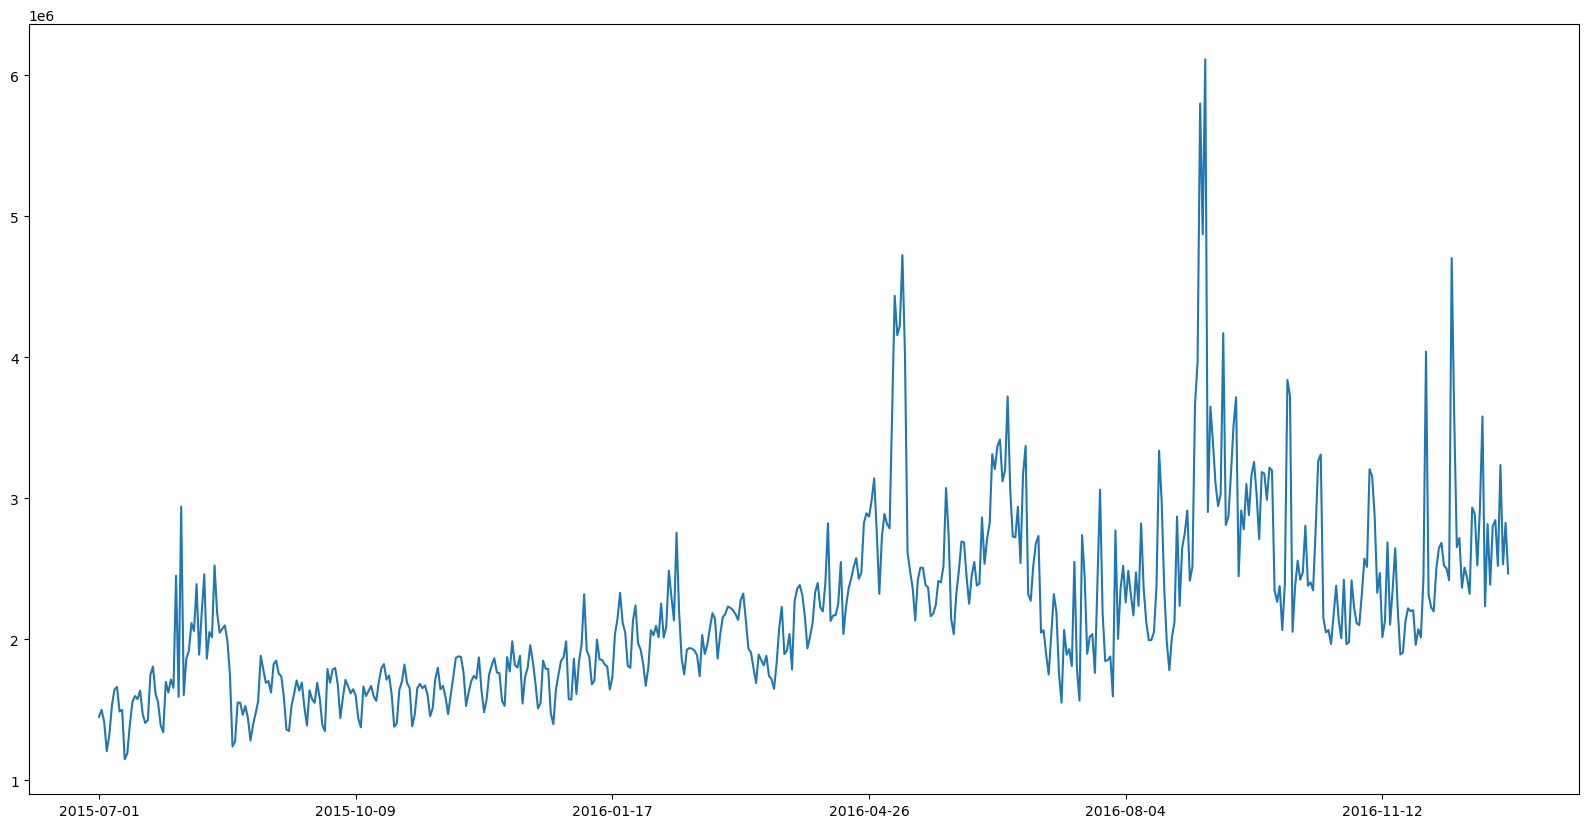

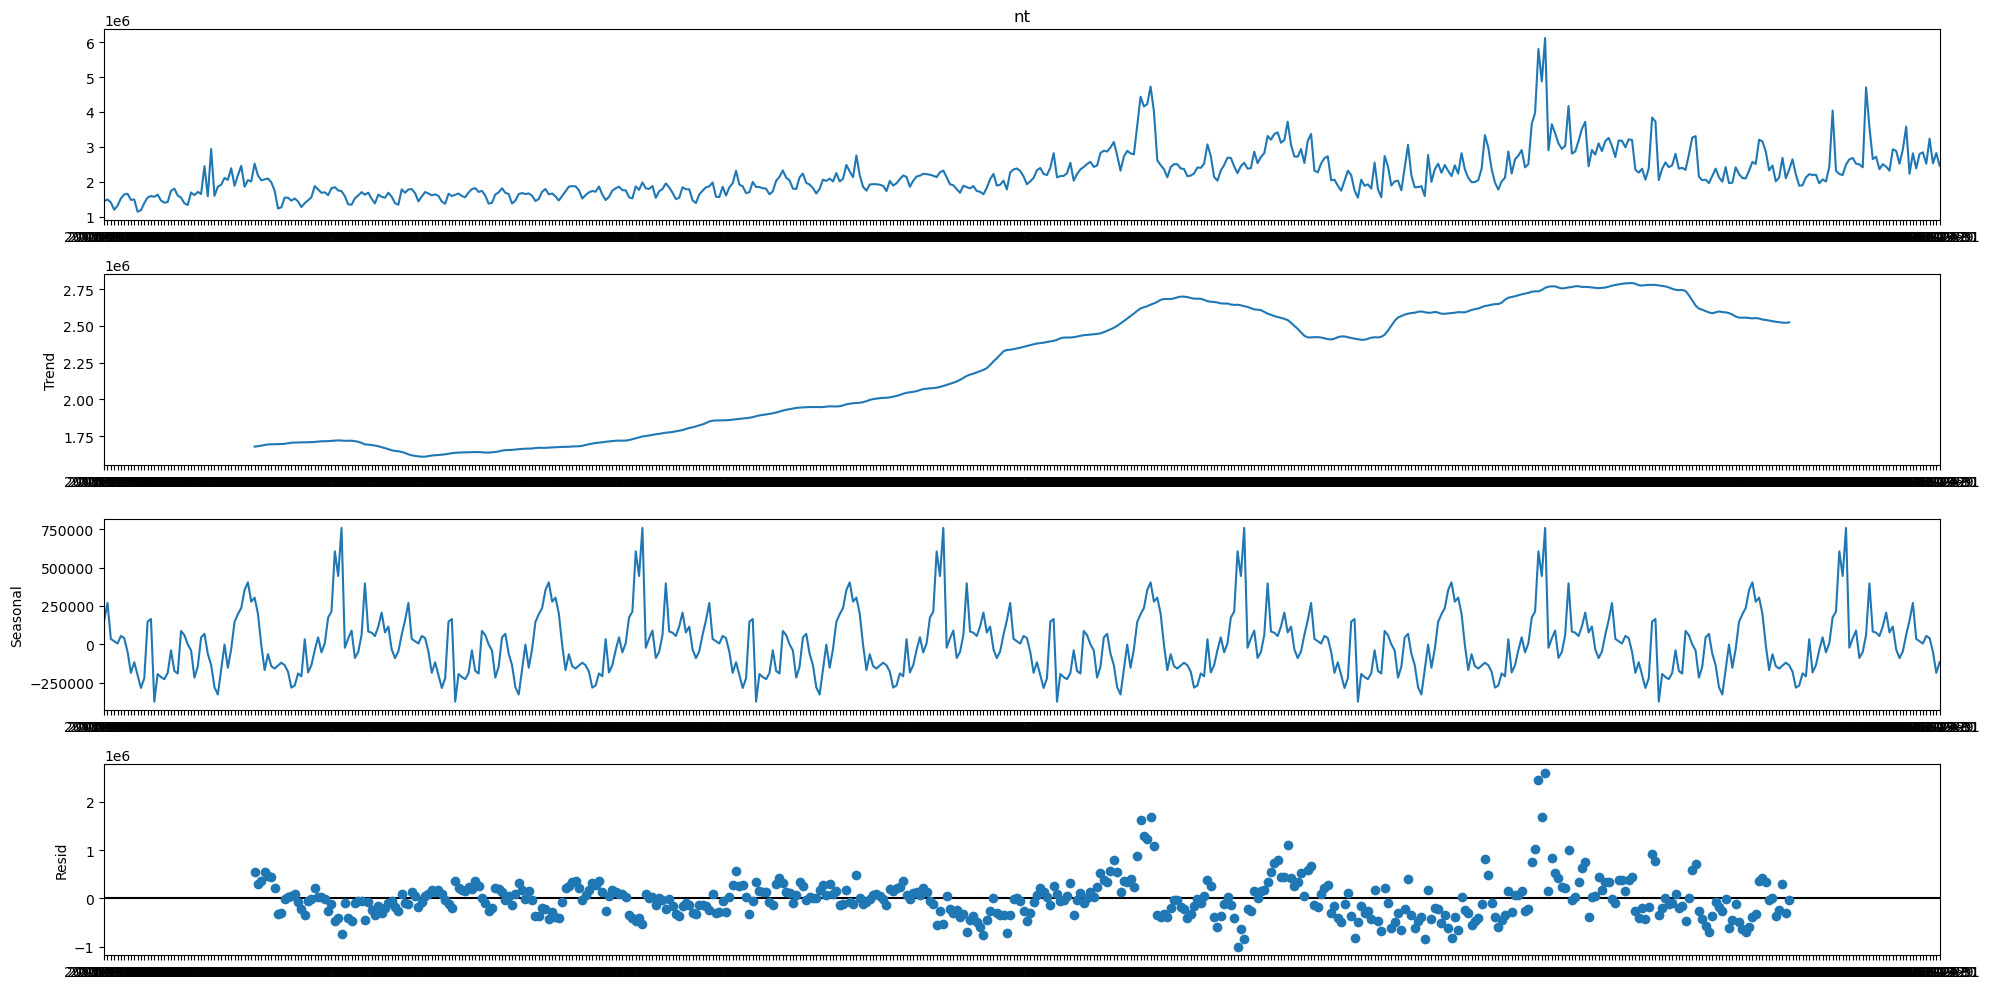

In [39]:
decomposition(adease1.nt)

# Differencing the time series

In [40]:
from matplotlib import pyplot

def differencing(language):
    diff = language.diff()
    pyplot.plot(diff)
    pyplot.show()

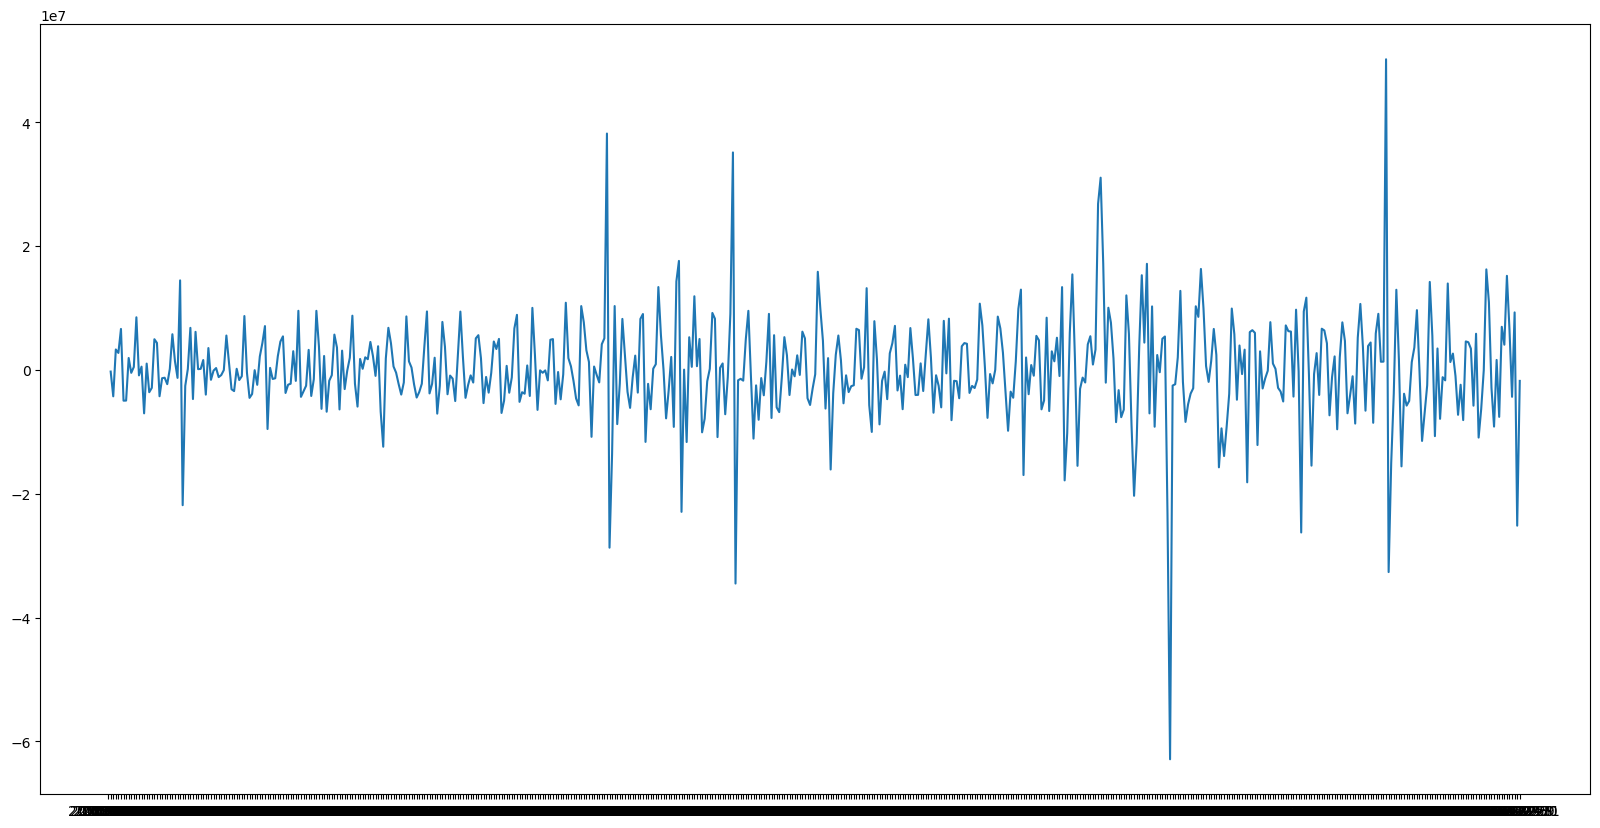

In [41]:
differencing(adease1.en)

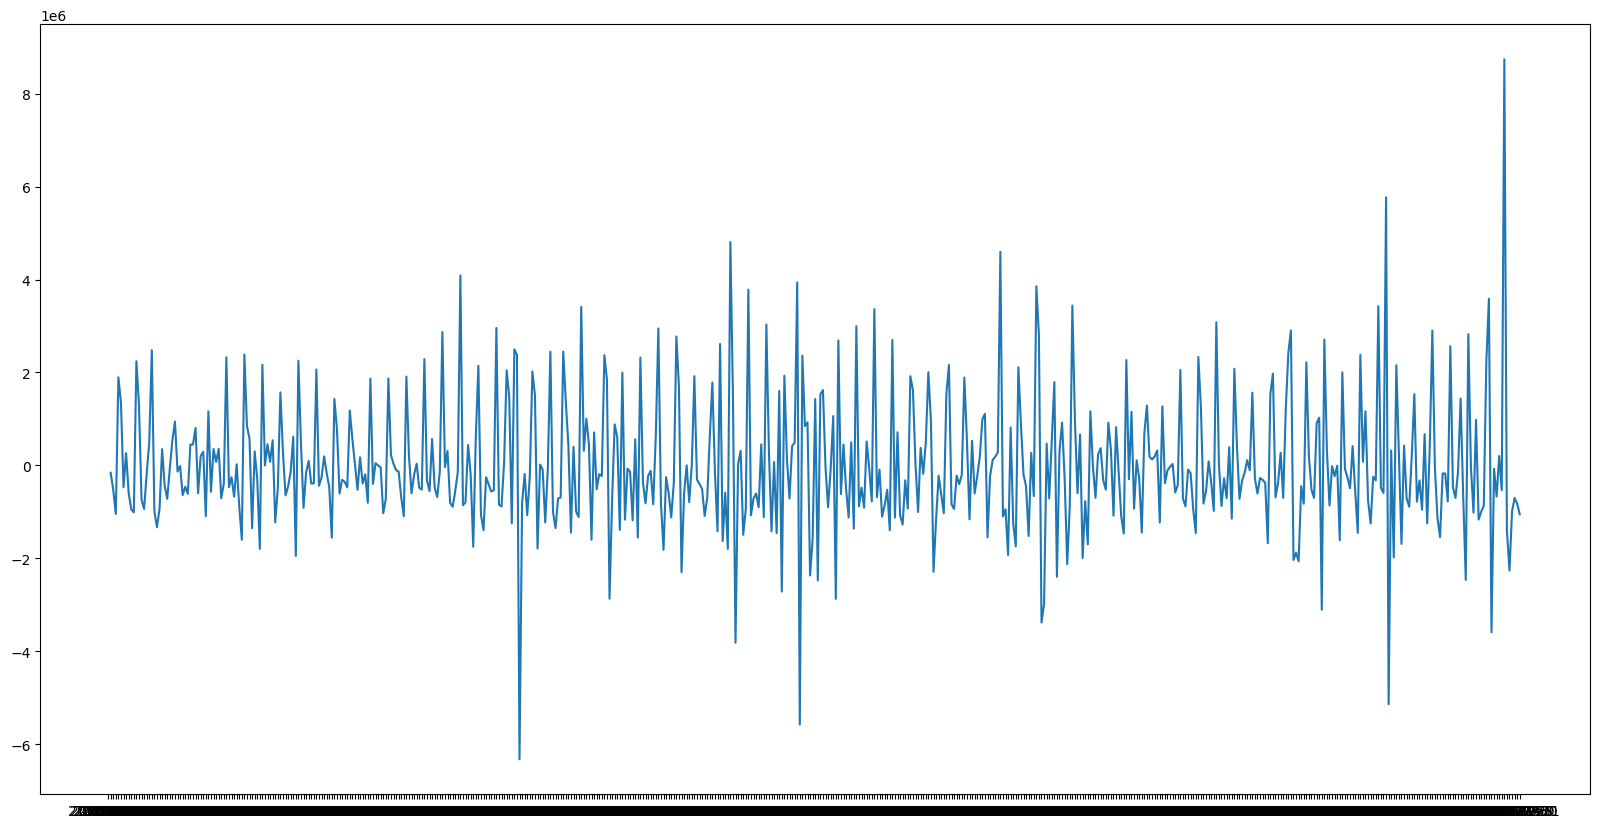

In [42]:
differencing(adease1.de)

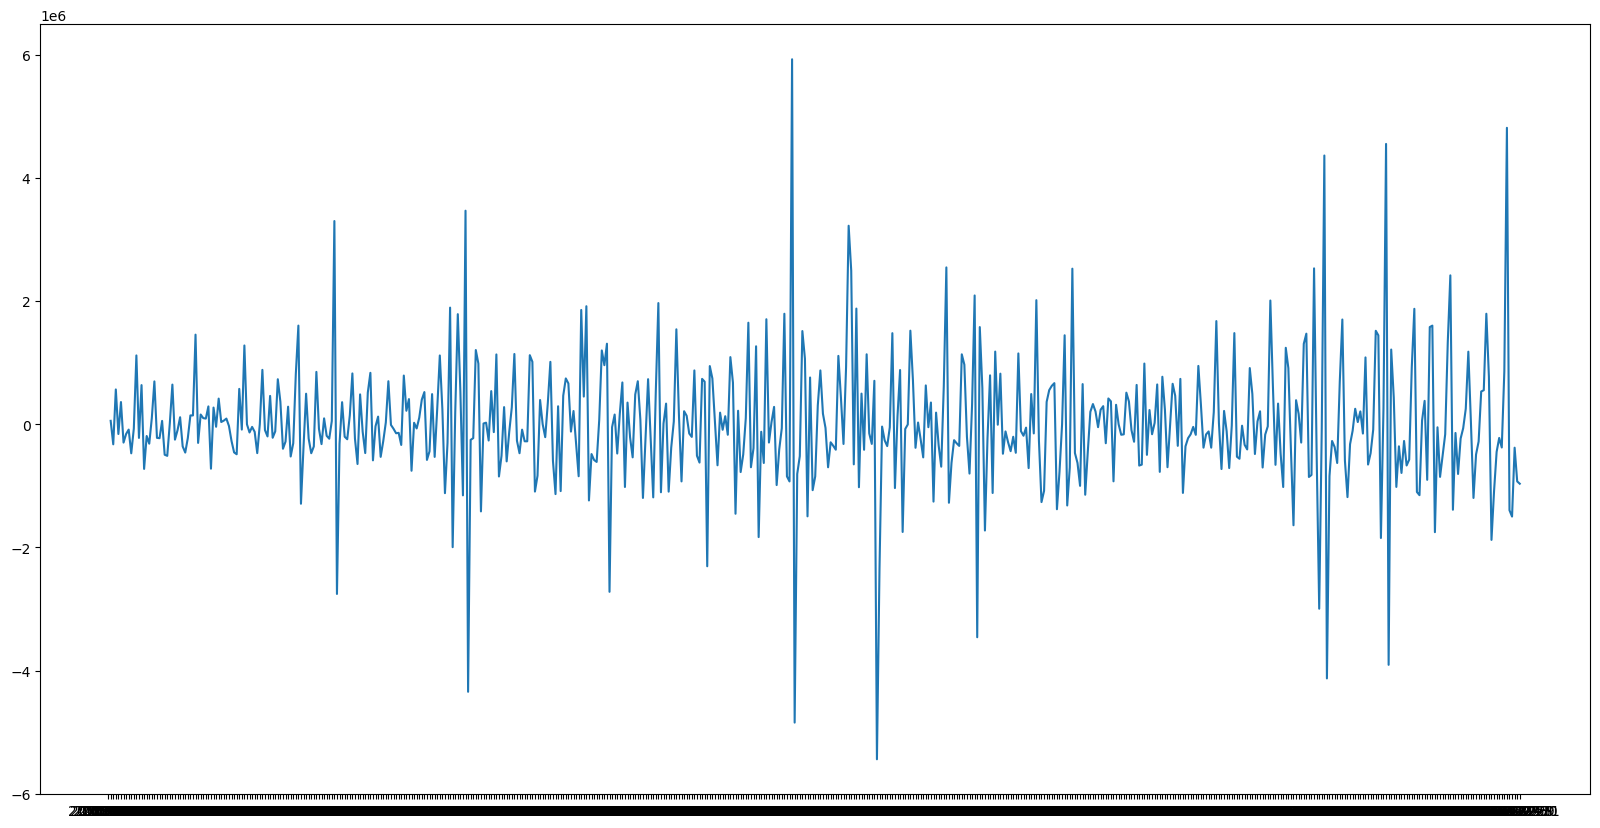

In [43]:
differencing(adease1.fr)

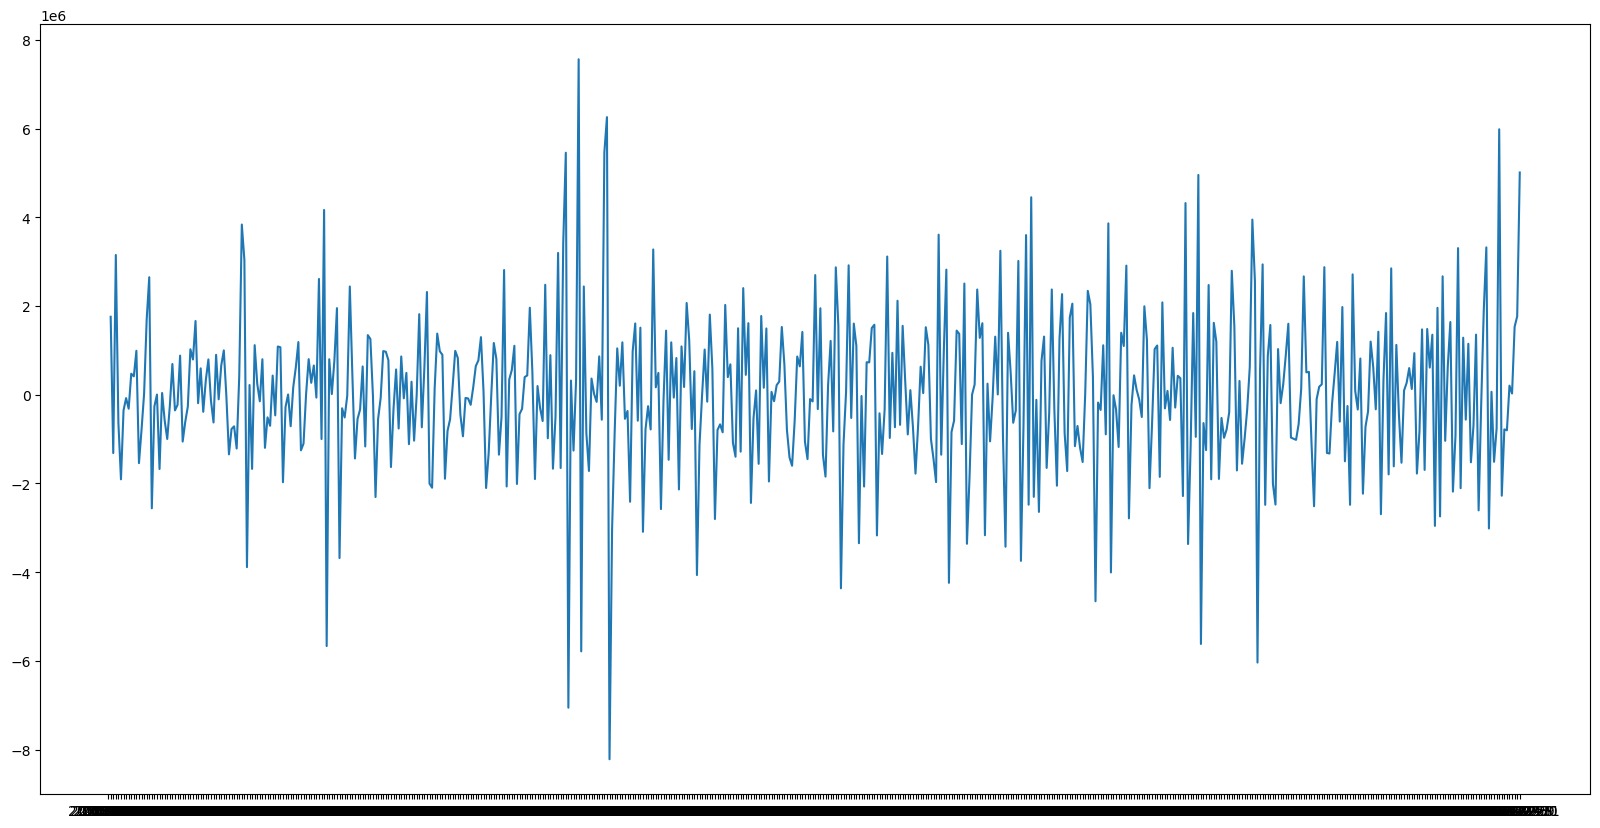

In [44]:
differencing(adease1.ja)

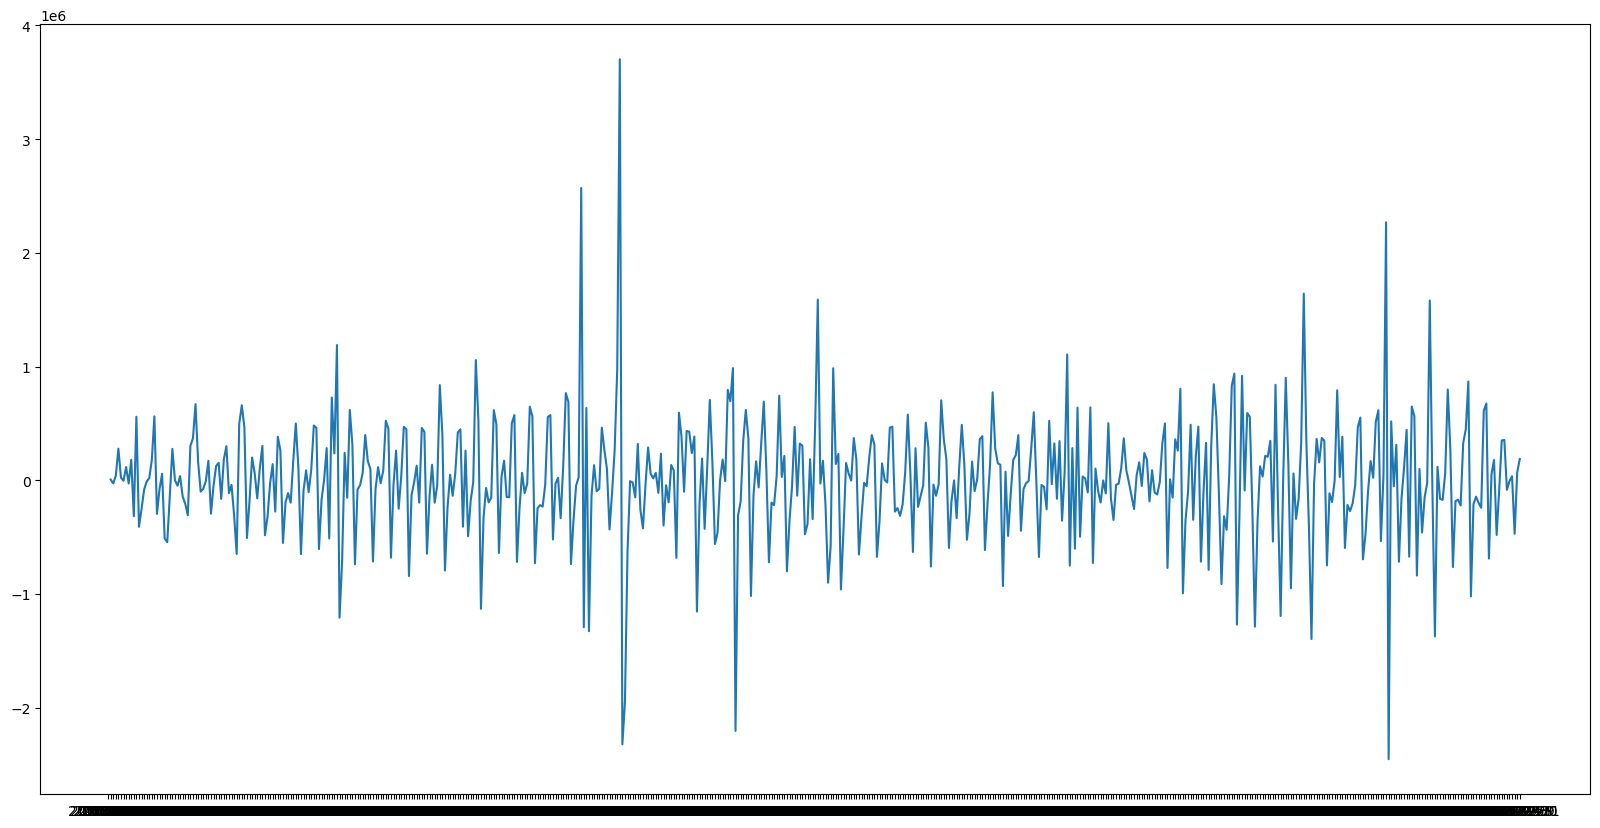

In [45]:
differencing(adease1.zh)

# Creating model training and forecasting

# ACF and PACF plot

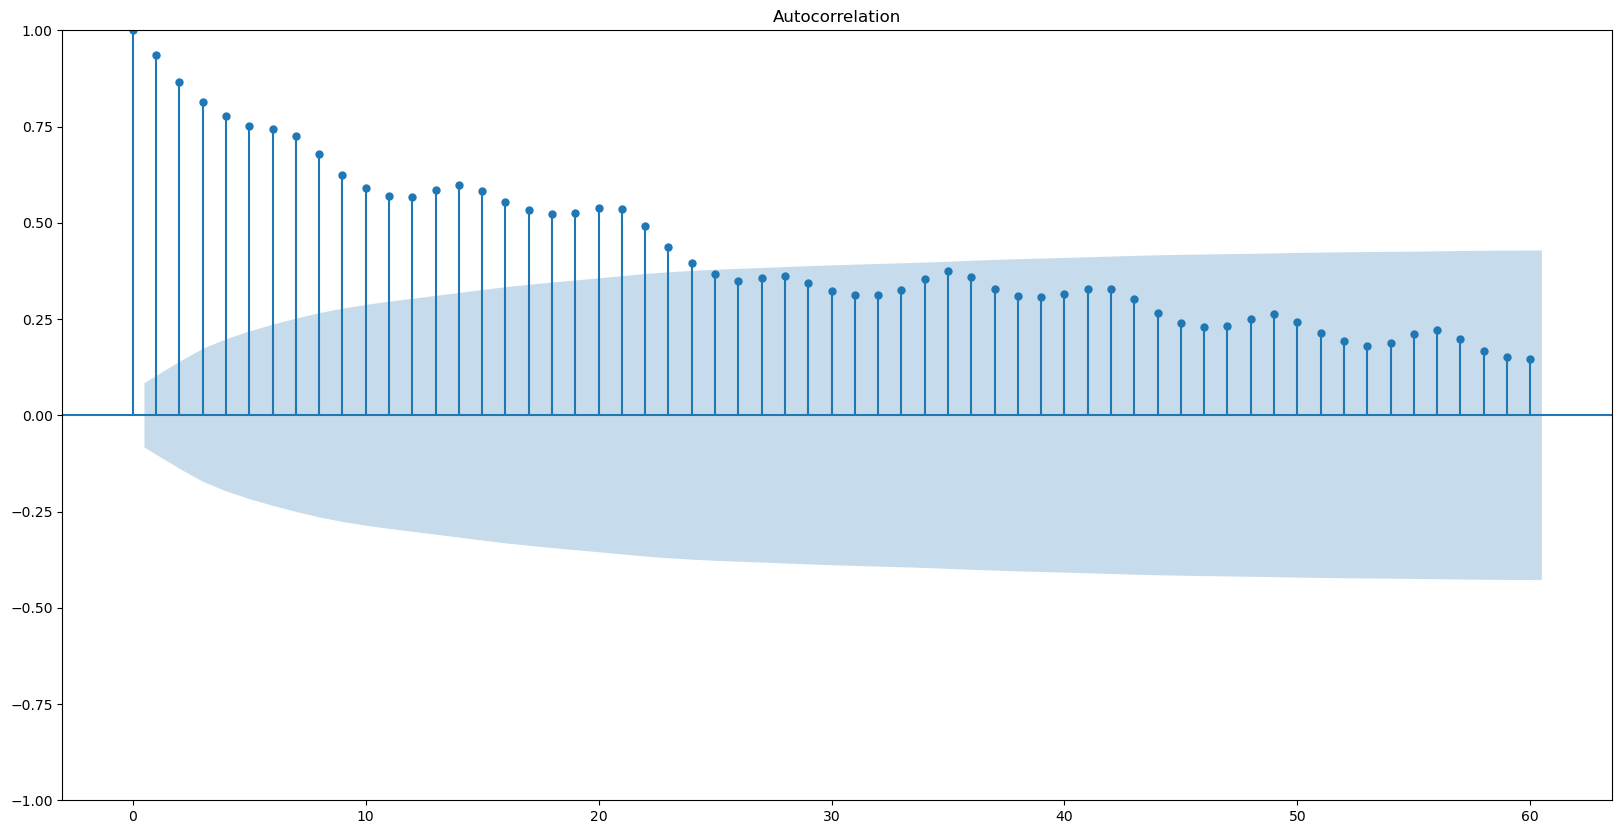

In [46]:
plot_acf(adease1.en, lags=60);

C:\Users\pgpra\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


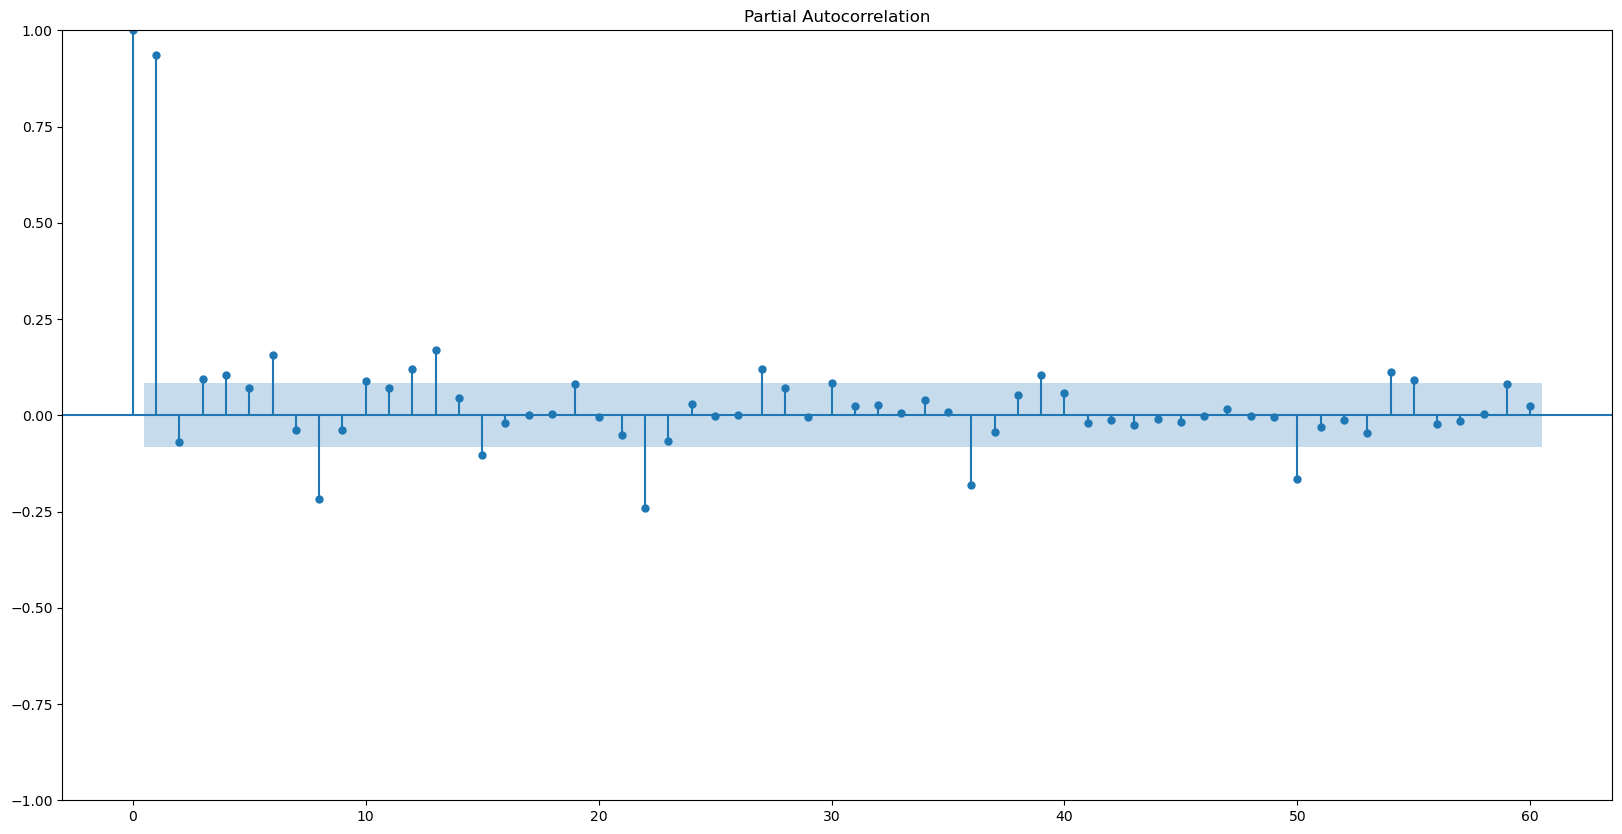

In [47]:
plot_pacf(adease1.en, lags=60);

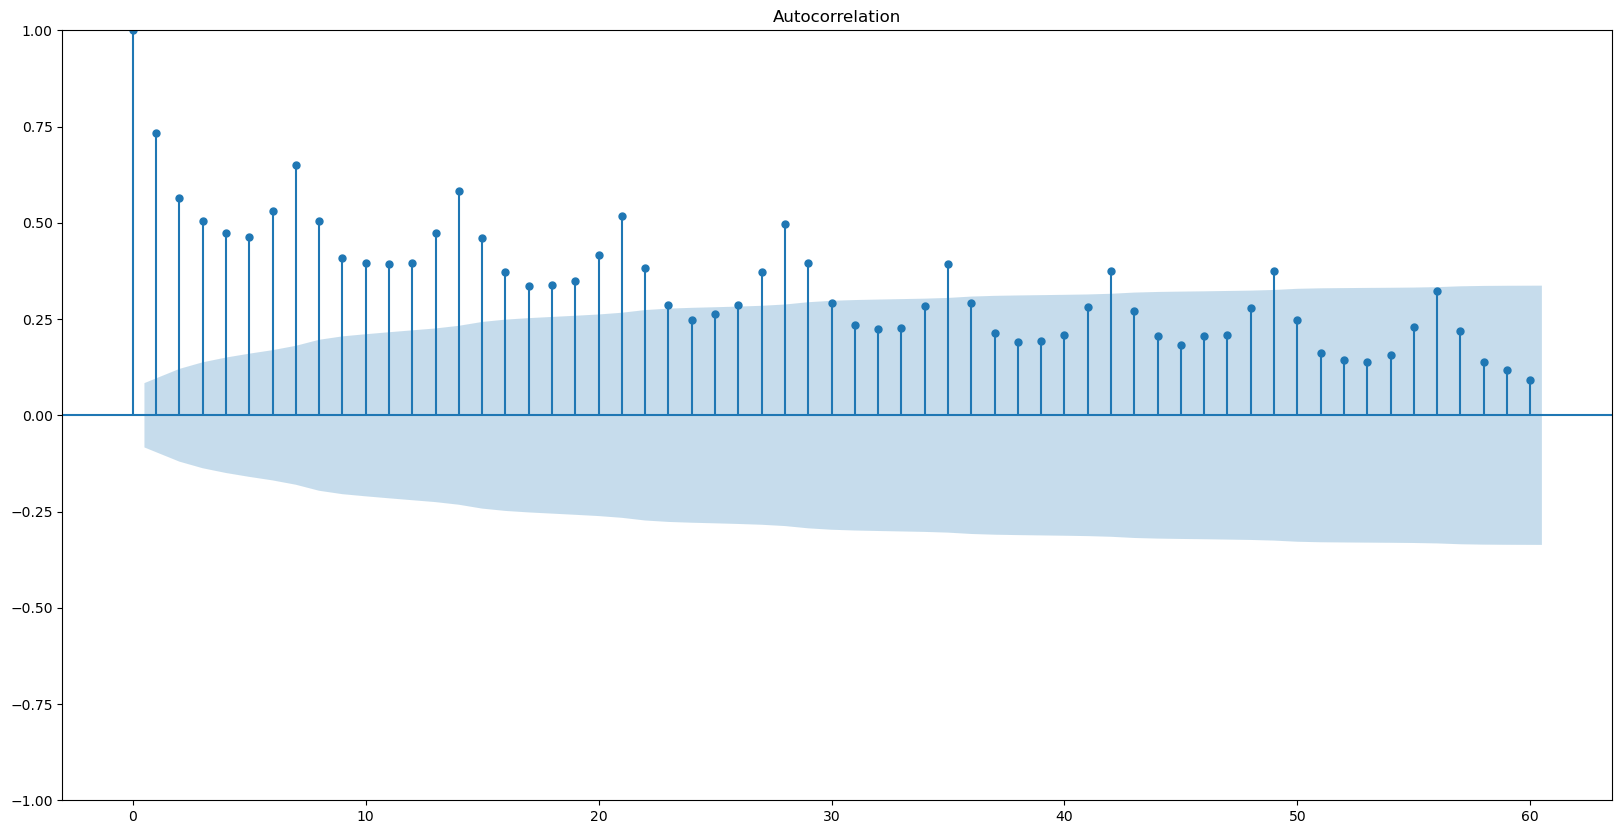

In [48]:
plot_acf(adease1.de, lags=60);

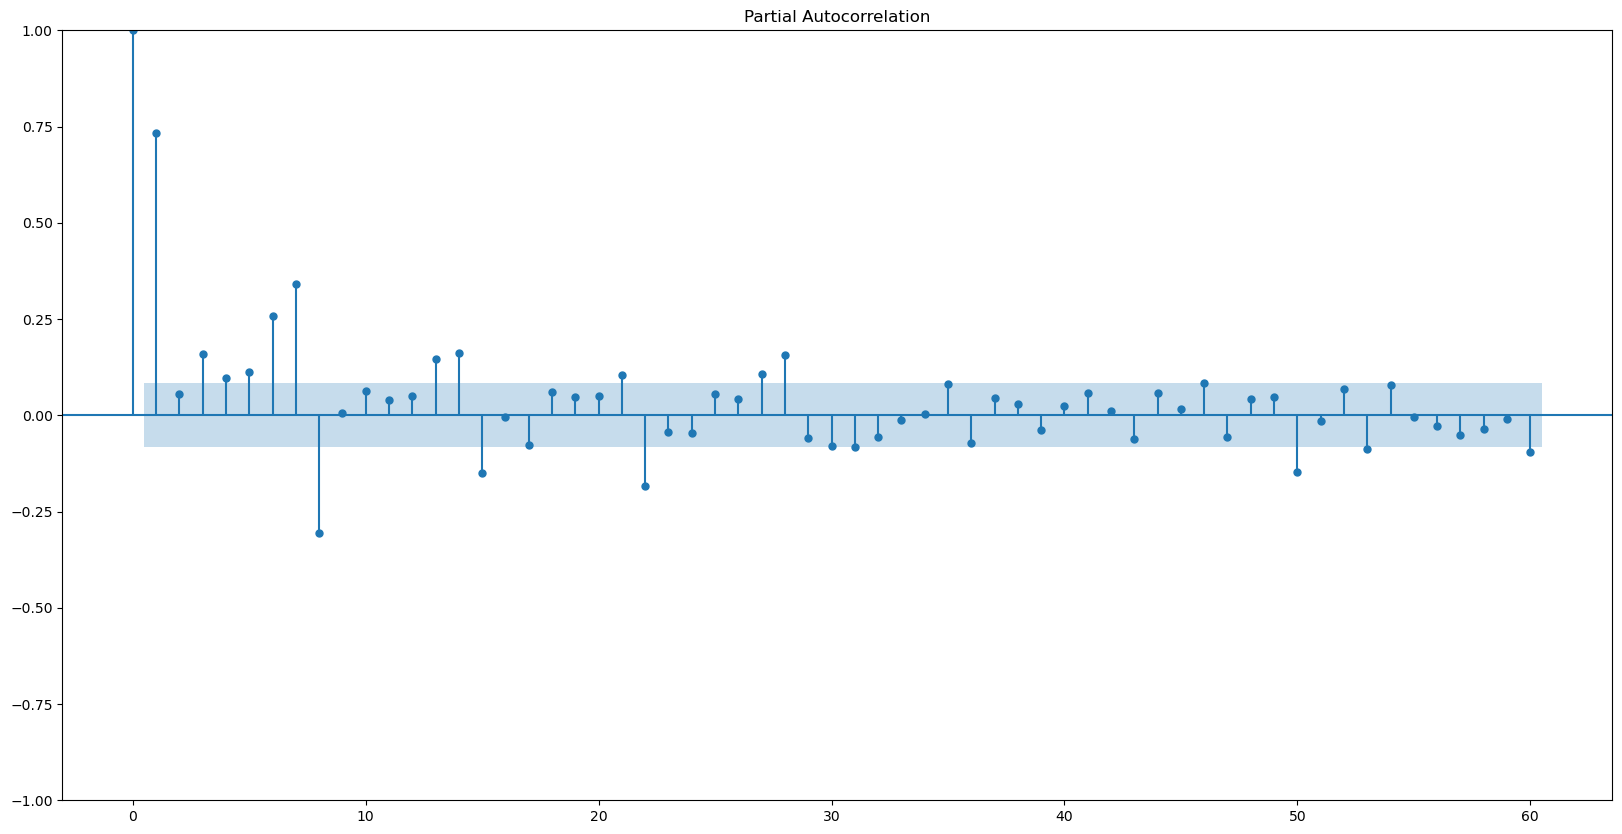

In [49]:
plot_pacf(adease1.de, lags=60);

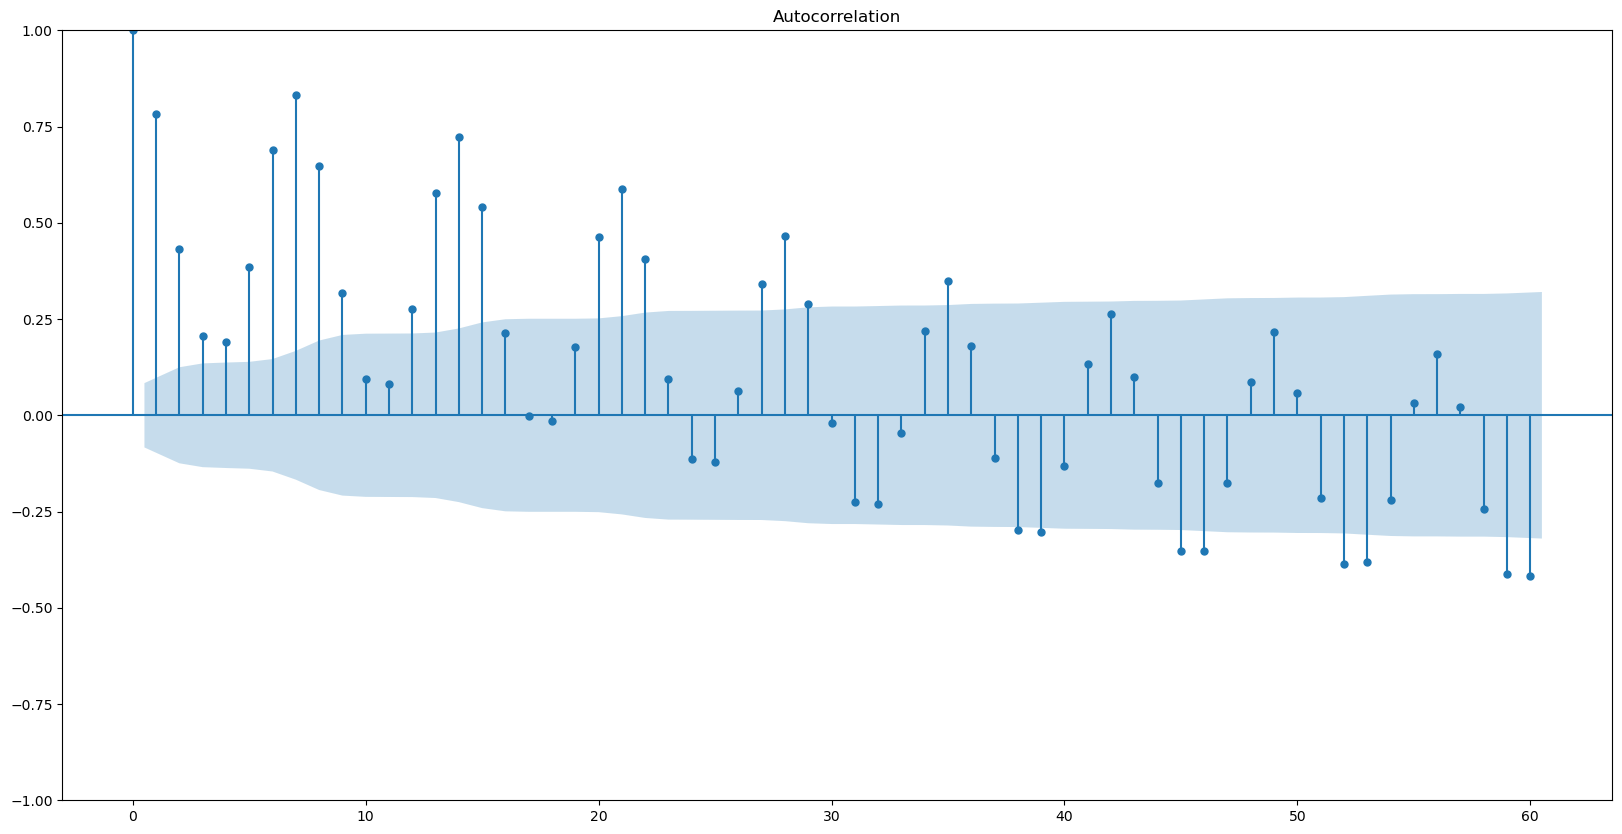

In [50]:
plot_acf(adease1.es, lags=60);

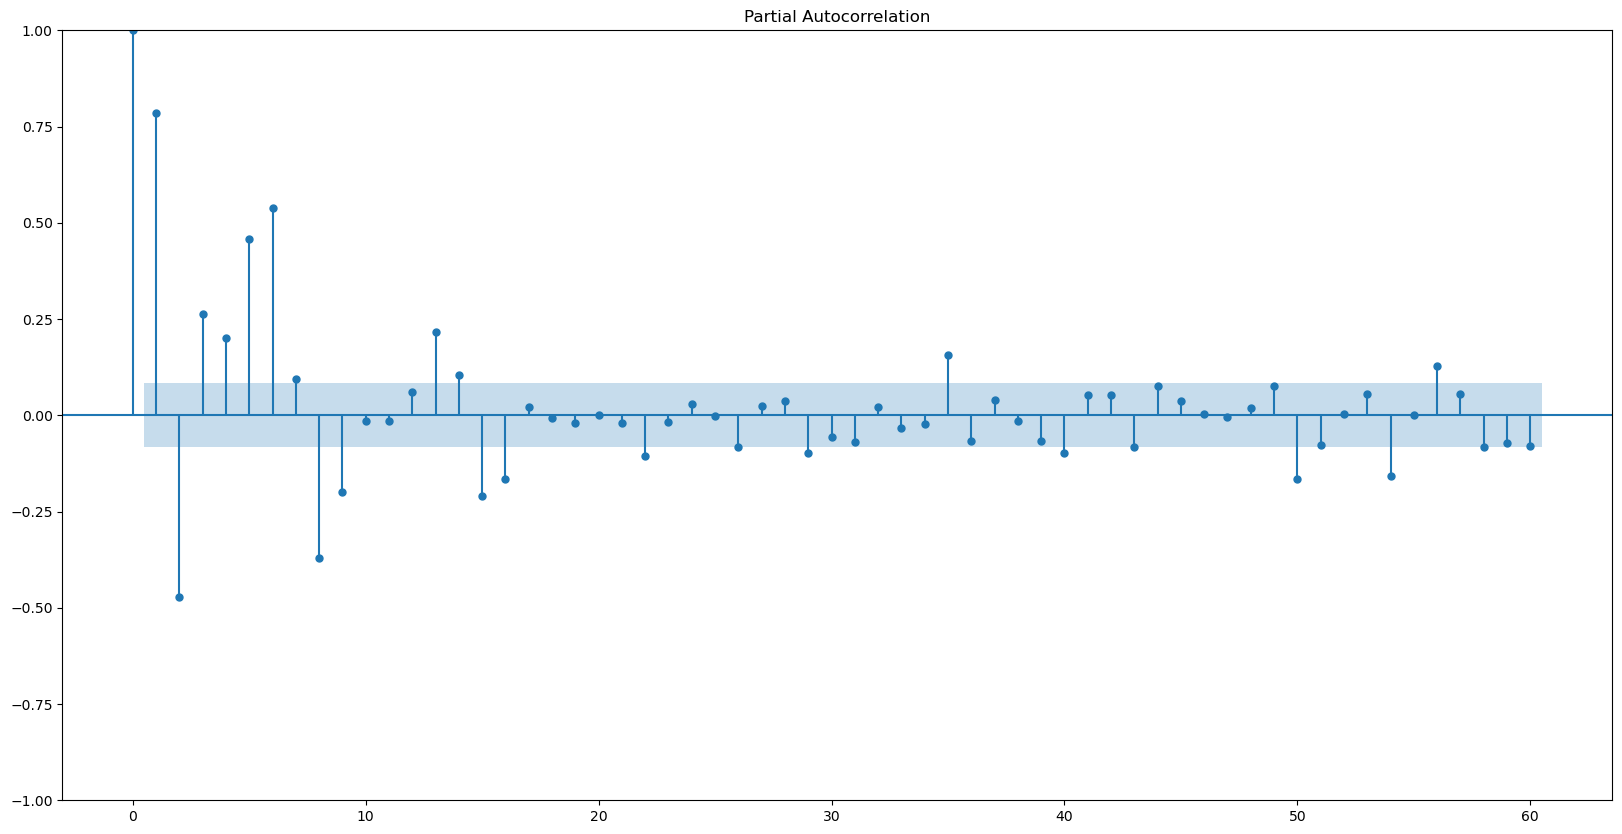

In [51]:
plot_pacf(adease1.es, lags=60);

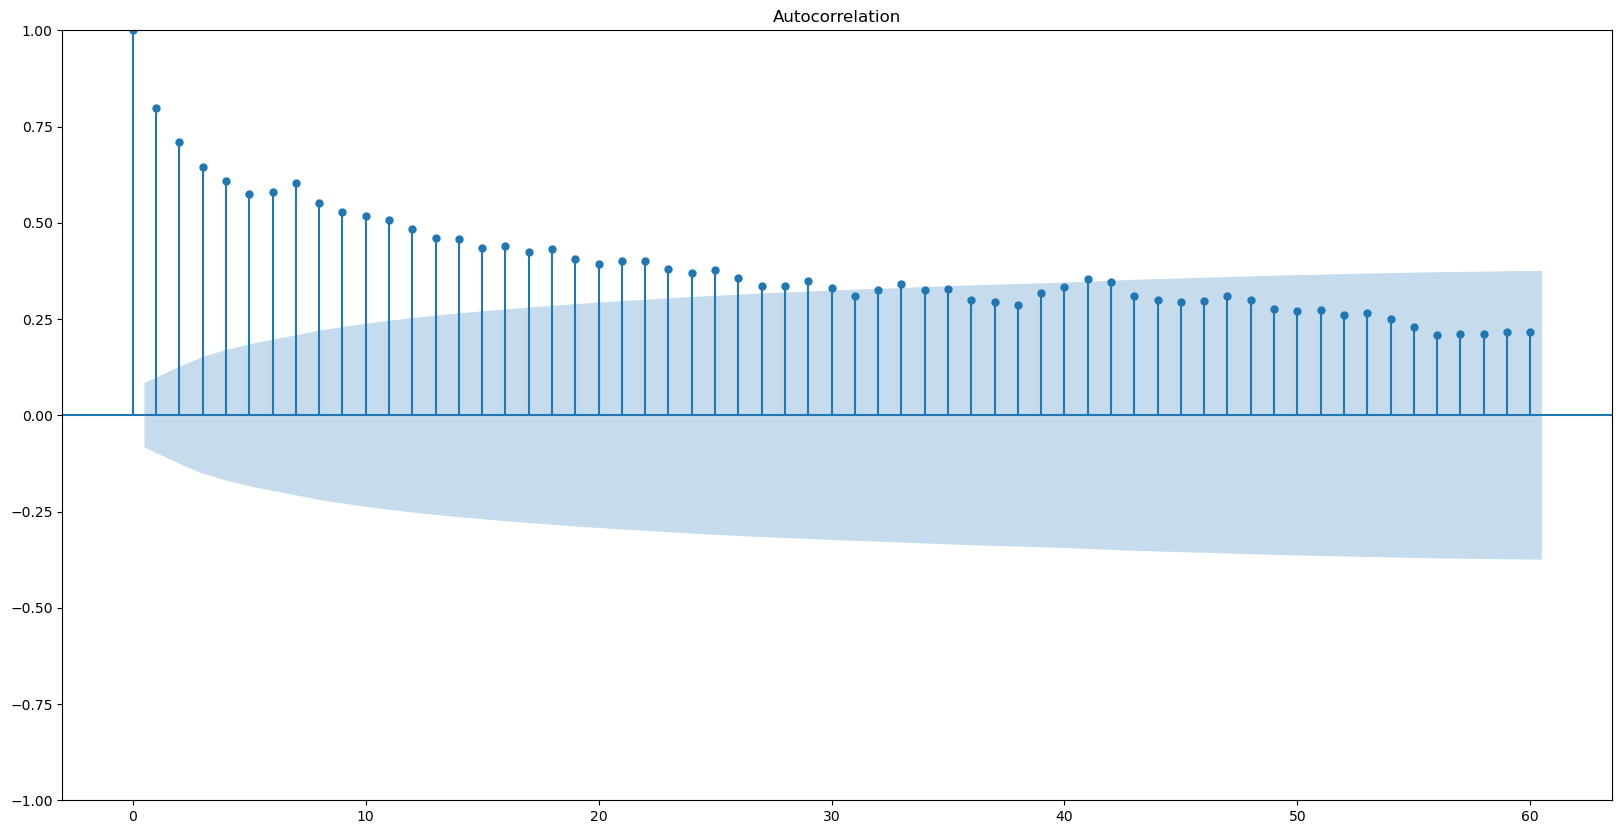

In [52]:
plot_acf(adease1.nt, lags=60);

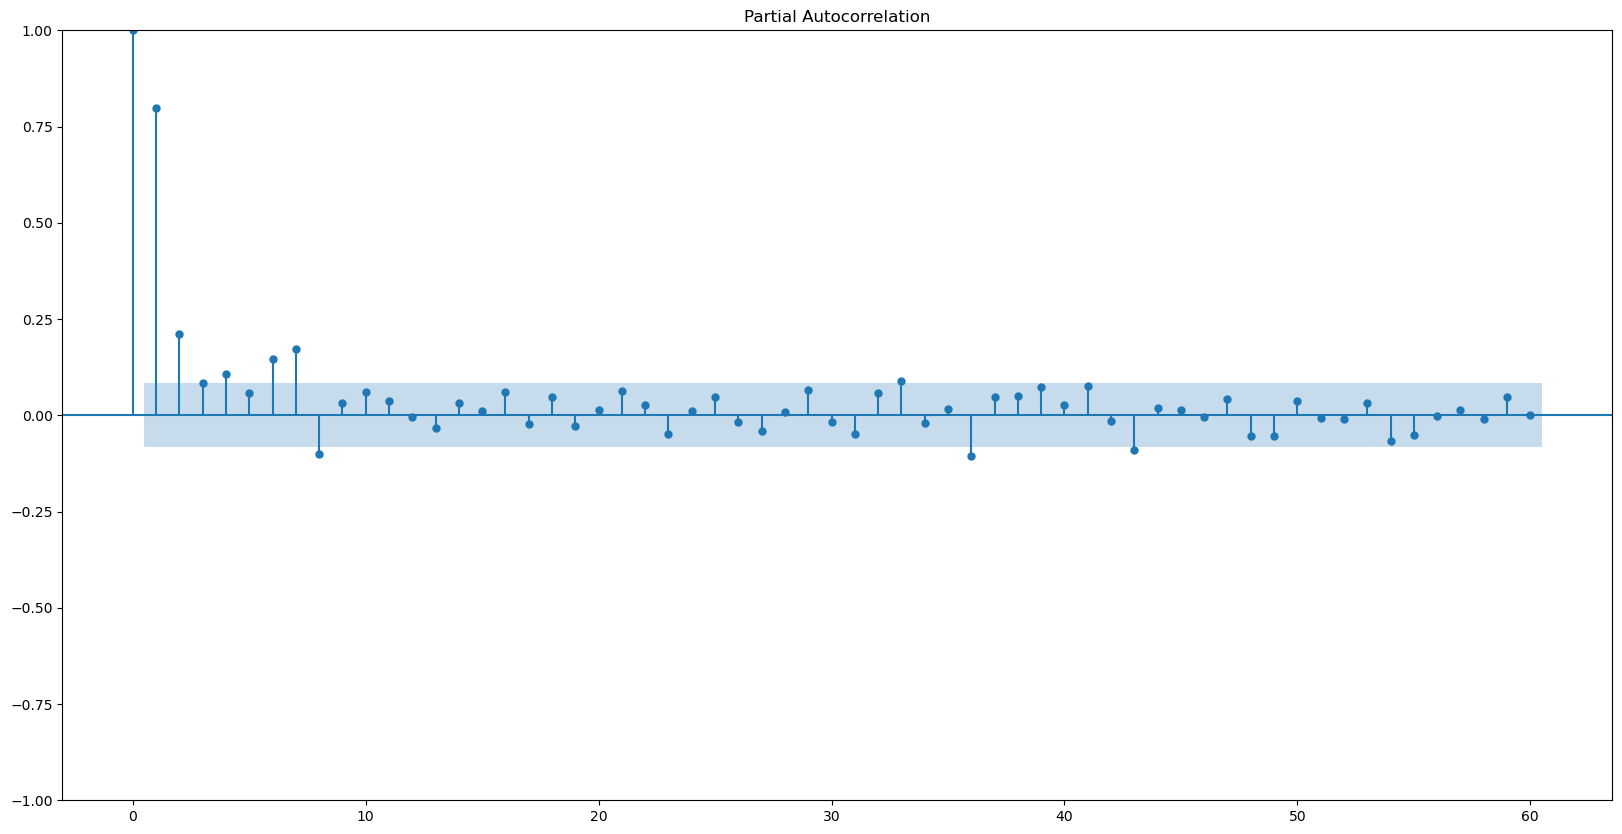

In [53]:
plot_pacf(adease1.nt, lags=60);

# Training the model

In [54]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted)*100, 3))

In [55]:
adease2 = copy.deepcopy(adease1)
adease2 = adease1.reset_index(drop=True)

In [56]:
train_x = adease2.loc[adease2.index < adease2.index[-30]].copy()
test_x = adease2.loc[adease2.index >= adease2.index[-30]].copy()

# ARIMA

MAE : 8439102.058
RMSE : 12092224.621
MAPE: 6.493


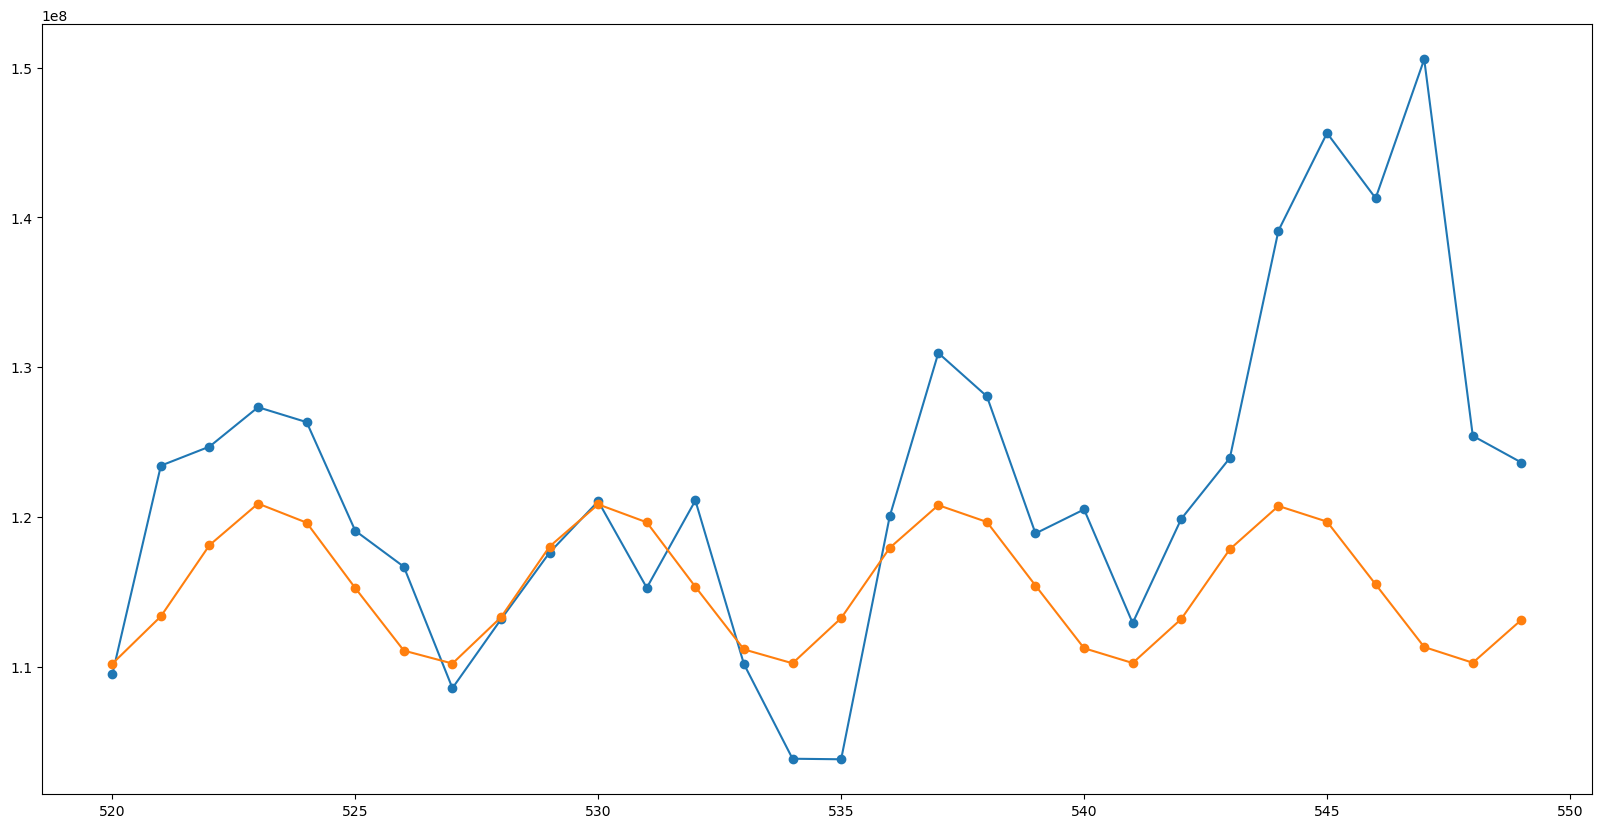

In [57]:
model = SARIMAX(train_x.en, order=(2, 1, 3)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=30)

test_x['en'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['en'], test_x['pred'])

In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     en   No. Observations:                  520
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -8972.412
Date:                Tue, 21 Nov 2023   AIC                          17956.824
Time:                        17:56:07   BIC                          17982.336
Sample:                             0   HQIC                         17966.819
                                - 520                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2491      0.003    396.061      0.000       1.243       1.255
ar.L2         -0.9980      0.003   -304.499      0.000      -1.004      -0.992
ma.L1         -1.3211      0.029    -46.053      0.000      -1.377      -1.265
ma.L2          1.0750      0.042     25.681      0.000       0.993       1.157
ma.L3         -0.0631      0.027     -2.297      0.022      -0.117      -0.009
sigma2      6.633e+13   4.28e-17   1.55e+30      0.000    6.63e+13    6.63e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              4628.48
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               5.17   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+45. Standard errors may be unstable.
"""

# SARIMAX

In [59]:
holiday = pd.read_csv('C:/DSML/Case study/AdEase/Exog_Campaign_eng.csv')
adease2['holiday'] = holiday['0']
adease2['holiday'] = adease2['holiday'].fillna(0)
train_x = adease2.loc[adease2.index < adease2.index[-30]].copy()
test_x = adease2.loc[adease2.index >= adease2.index[-30]].copy()

In [60]:
train_x

DATE          de           en          es          fr          ja         nt  \
0     13299837.0   84712190.0  15278553.0   8458638.0  11863200.0  1451216.0   
1     13142154.0   84438545.0  14601013.0   8512952.0  13620792.0  1499552.0   
2     12615201.0   80167728.0  13427632.0   8186030.0  12305383.0  1415102.0   
3     11573244.0   83463204.0  12606538.0   8749842.0  15456239.0  1207208.0   
4     13470112.0   86198637.0  13710356.0   8590493.0  14827204.0  1318756.0   
..           ...          ...         ...         ...         ...        ...   
515   18528297.0  127490837.0  19187988.0  14110096.0  17341376.0  2013668.0   
516   18470542.0  116790477.0  19451796.0  12357078.0  14384970.0  2433463.0   
517   17334434.0  120242864.0  22934715.0  12306299.0  16344040.0  4041040.0   
518   15789877.0  112338480.0  19853189.0  11450827.0  13600733.0  2319105.0   
519   15617569.0  111159461.0  17732257.0  10938734.0  16269616.0  2226856.0   

DATE          ru         zh  holiday  
0      9463854.0  4144988.0      0.0  
1      9627643.0  4151189.0      0.0  
2      8923463.0  4123659.0      0.0  
3      8393214.0  4163448.0      0.0  
4      8938528.0  4441286.0      0.0  
..           ...        ...      ...  
515   16531335.0  7567627.0      0.0  
516   16001150.0  6194615.0      0.0  
517   16644184.0  6313203.0      0.0  
518   15716193.0  6149293.0      0.0  
519   15932902.0  5976786.0      0.0  

[520 rows x 9 columns]

In [61]:
model1 = SARIMAX(train_x.en, exog=train_x.holiday, order=(2, 1, 3), seasonal_order=(1,0,1,30)) 
results1 = model1.fit(disp=False)


C:\Users\pgpra\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [62]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                   en   No. Observations:                  520
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 30)   Log Likelihood               -8968.917
Date:                              Tue, 21 Nov 2023   AIC                          17955.833
Time:                                      17:56:26   BIC                          17994.100
Sample:                                           0   HQIC                         17970.825
                                              - 520                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     2.803e+06   6.13e-08   4.57e+13      0.000     2.8e+06     2.8e+06
ar.L1          1.2423      0.005    255.840      0.000       1.233       1.252
ar.L2         -0.9965      0.004   -225.147      0.000      -1.005      -0.988
ma.L1         -1.3365      0.025    -53.066      0.000      -1.386      -1.287
ma.L2          1.1161      0.036     31.157      0.000       1.046       1.186
ma.L3         -0.1075      0.027     -4.024      0.000      -0.160      -0.055
ar.S.L30       0.9296      0.423      2.196      0.028       0.100       1.759
ma.S.L30      -0.9472      0.415     -2.285      0.022      -1.760      -0.135
sigma2       6.61e+13   1.14e-13   5.79e+26      0.000    6.61e+13    6.61e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4812.06
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               5.12   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+41. Standard errors may be unstable.
"""

In [63]:
start=len(train_x)
end=len(train_x)+len(test_x)-1

In [64]:
exog_forecast = test_x[['holiday']]  
predictions = results1.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

MAE : 8934067.545
RMSE : 12390810.343
MAPE: 6.904


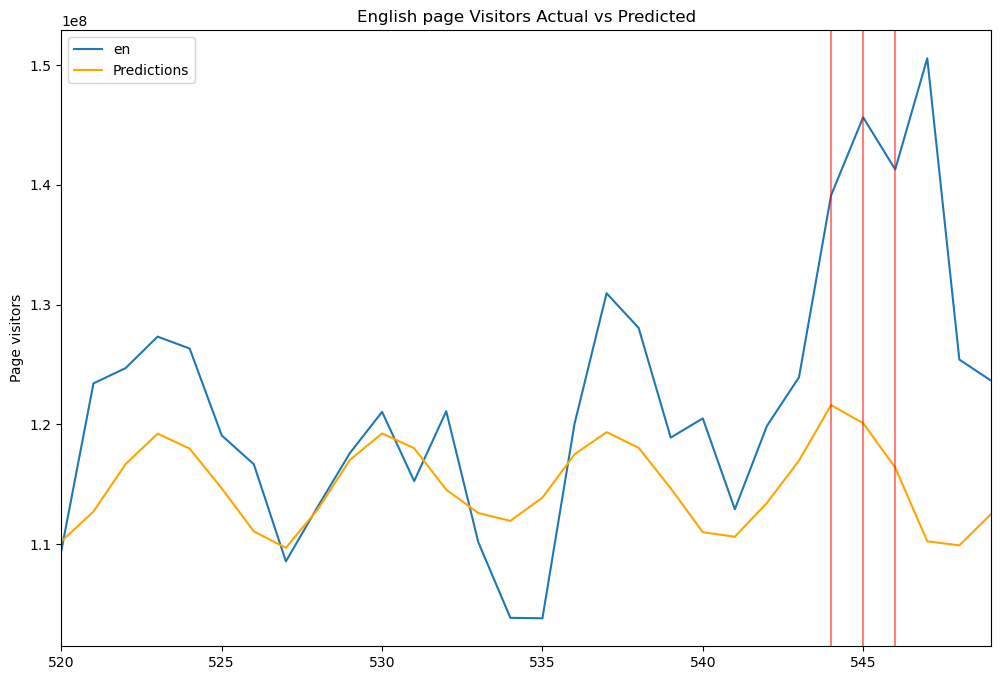

In [65]:
performance(test_x['en'], predictions)
# Plot predictions against known values
title='English page Visitors Actual vs Predicted'
ylabel='Page visitors'
xlabel=''

ax = test_x['en'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test_x.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

# Forecasting from Facebook Prophet

In [66]:
from prophet import Prophet

In [67]:
holiday = pd.read_csv('C:/DSML/Case study/AdEase/Exog_Campaign_eng.csv')
adease1['holiday'] = holiday['0']
adease1['holiday'] = adease1['holiday'].fillna(0)

In [68]:
adease1 = adease1.reset_index()

In [69]:
adease1

DATE       index          de           en          es          fr          ja  \
0     2015-07-01  13299837.0   84712190.0  15278553.0   8458638.0  11863200.0   
1     2015-07-02  13142154.0   84438545.0  14601013.0   8512952.0  13620792.0   
2     2015-07-03  12615201.0   80167728.0  13427632.0   8186030.0  12305383.0   
3     2015-07-04  11573244.0   83463204.0  12606538.0   8749842.0  15456239.0   
4     2015-07-05  13470112.0   86198637.0  13710356.0   8590493.0  14827204.0   
..           ...         ...          ...         ...         ...         ...   
545   2016-12-27  20229121.0  145628731.0  15945353.0  15281470.0  16123301.0   
546   2016-12-28  19245058.0  141278366.0  16577375.0  13781521.0  16150715.0   
547   2016-12-29  18545710.0  150557534.0  15647135.0  13399796.0  17682688.0   
548   2016-12-30  17717316.0  125404585.0  11560095.0  12471074.0  19450687.0   
549   2016-12-31  16665282.0  123623809.0  11077924.0  11504691.0  24460799.0   

DATE         nt          ru         zh  holiday  
0     1451216.0   9463854.0  4144988.0      0.0  
1     1499552.0   9627643.0  4151189.0      0.0  
2     1415102.0   8923463.0  4123659.0      0.0  
3     1207208.0   8393214.0  4163448.0      0.0  
4     1318756.0   8938528.0  4441286.0      0.0  
..          ...         ...        ...      ...  
545   2521523.0  15040168.0  6478442.0      0.0  
546   3236182.0  14000319.0  6513400.0      0.0  
547   2532184.0  13478977.0  6042545.0      0.0  
548   2826586.0  12066750.0  6111203.0      0.0  
549   2467691.0  13223033.0  6298565.0      0.0  

[550 rows x 10 columns]

In [70]:
adease1['ds'] = adease1['index']
adease1['y'] = adease1['en']

In [71]:
fb_df = adease1[['ds','y','holiday']].copy()
fb_df.columns = ['ds', 'y', 'exog']
fb_df.head()

ds           y  exog
0  2015-07-01  84712190.0   0.0
1  2015-07-02  84438545.0   0.0
2  2015-07-03  80167728.0   0.0
3  2015-07-04  83463204.0   0.0
4  2015-07-05  86198637.0   0.0

# prophet without exogenous variable

17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing


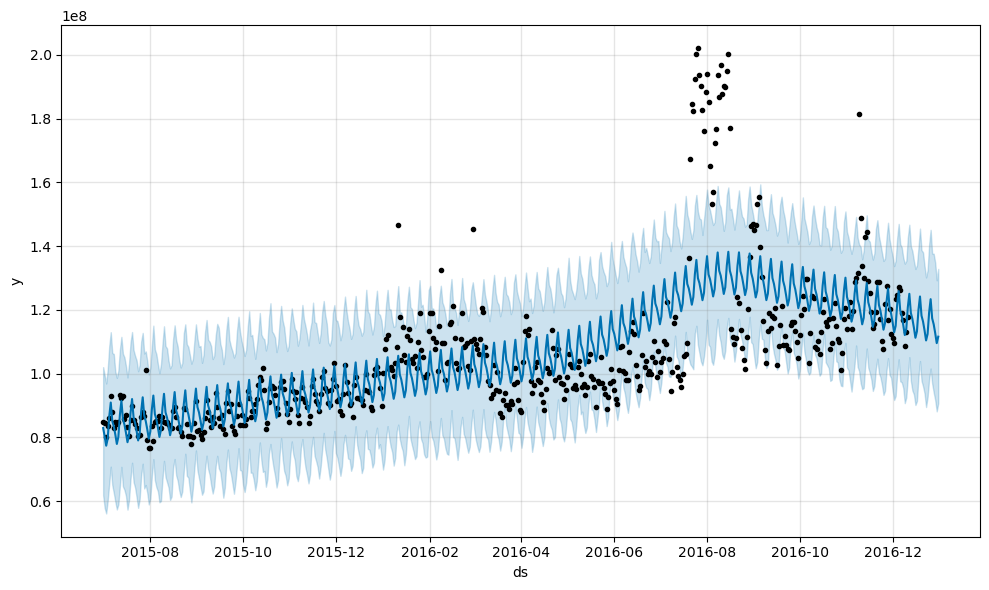

In [72]:
from prophet import Prophet
m = Prophet(weekly_seasonality=True)
m.fit(fb_df[['ds', 'y']][:-20])
future = m.make_future_dataframe(periods=20,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

# prophet with exogenous variable¶

17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:29 - cmdstanpy - INFO - Chain [1] done processing


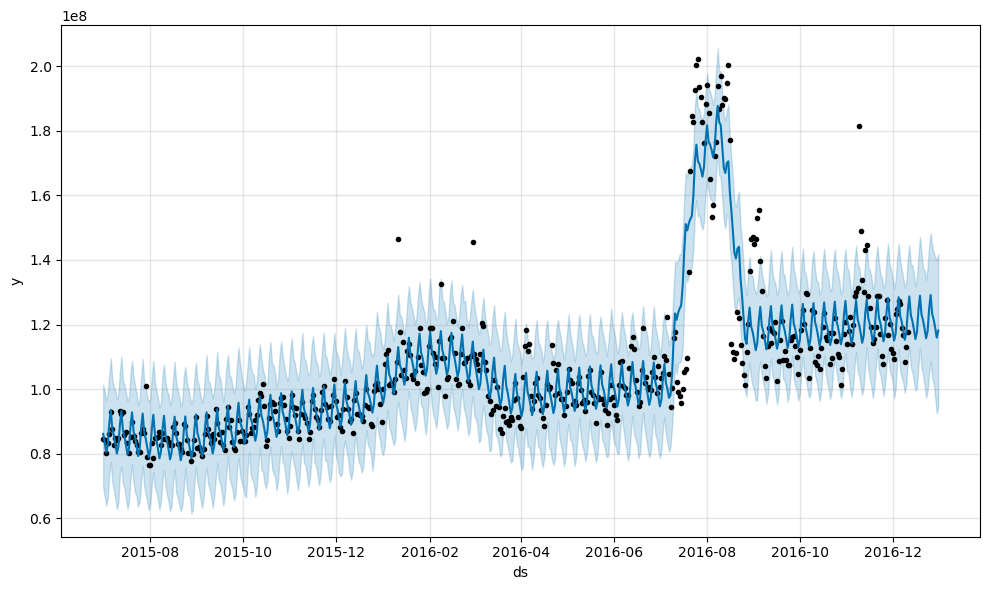

In [73]:
m2=Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=1)
m2.add_regressor('exog')
m2.fit(fb_df[:-20])
forecast2 = m2.predict(fb_df)
fig = m2.plot(forecast2)

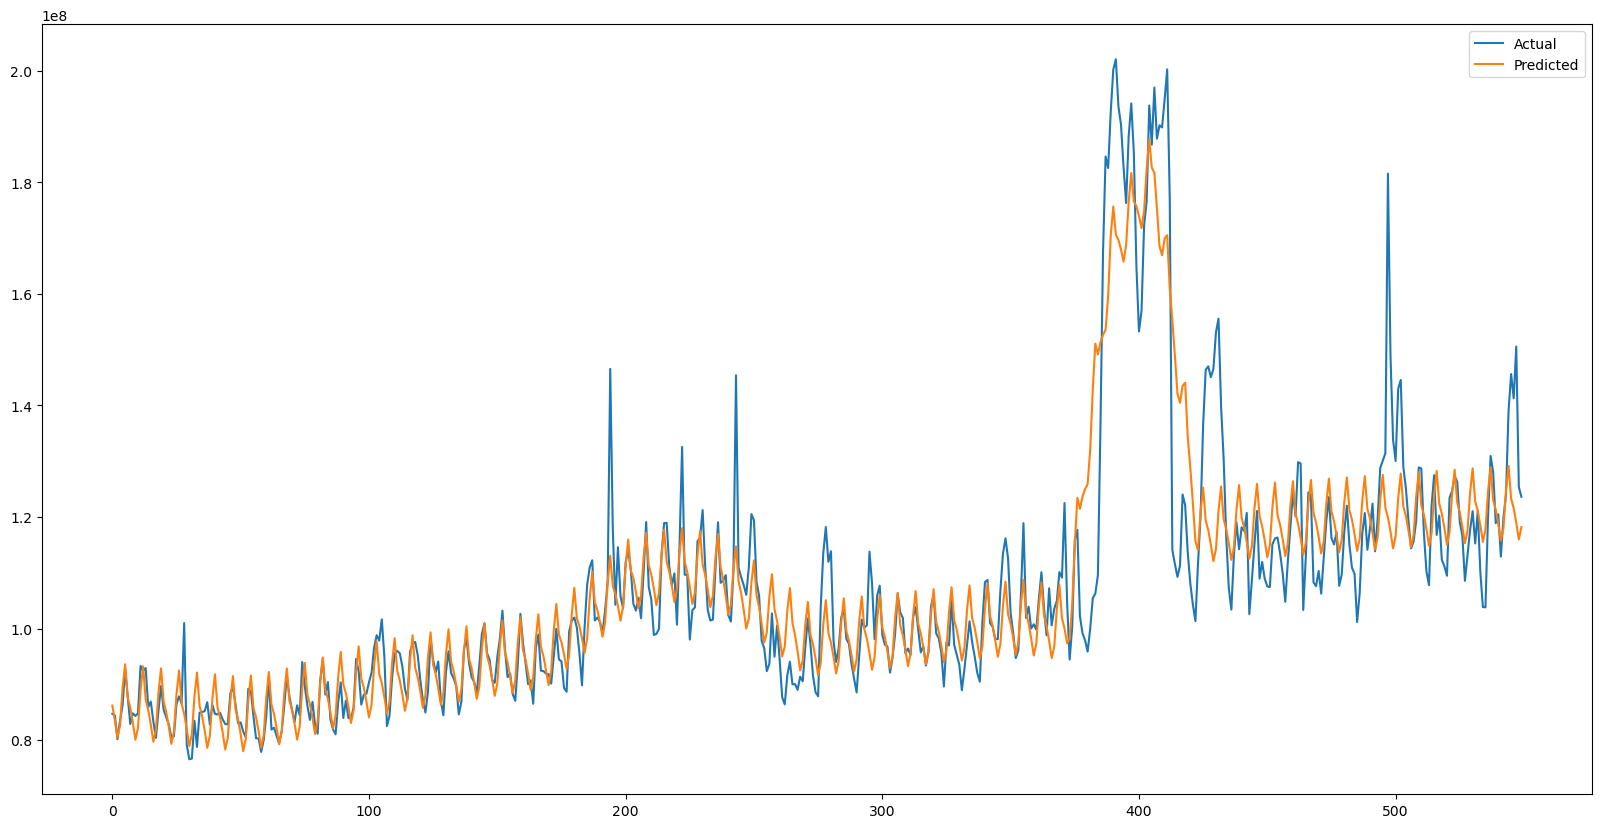

In [74]:
y_true = fb_df['y'].values
y_pred = forecast2['yhat'].values

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [75]:
mape = np.mean(np.abs(forecast2['yhat'][-20:] - fb_df['y'][-20:].values)/np.abs(fb_df['y'][-20:].values))
print("mape:",mape)

mape: 0.06599740555982832


# Finding a way through grid search to find the best params for at least 1 modeling approach.

In [76]:
def grid_search(df):
    values = [0,1,2,3]
    mape = 100
    val = [0,0,0]
    for p in values:
        for d in values:
            for q in values:
                try:
                    model = SARIMAX(df[:-20], order=(p,d,q))
                    model_fit = model.fit(disp=-1)
                    fc, se, conf = model_fit.forecast(20, alpha=0.02)
                    x = np.mean(np.abs(fc - df[-20:].values)/np.abs(df[-20:].values))
                    if(x < mape):
                        mape = x
                        val = [p,d,q]

                except:
                    pass

    return(mape, val)

In [77]:
def arima(train,test,val):
    model = SARIMAX(train, order=(val[0], val[1], val[2]))
    fitted = model.fit(disp=-1)

  # Forecast
    fc = fitted.forecast(30, alpha=0.02)

    fc_series = pd.Series(fc, index=test.index)

  # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
    rmse = np.mean((fc - test.values)**2)**.5
    print("mape:",mape)
    print("rsme:",rmse)
    return (fc)

language:  de
100 [0, 0, 0]


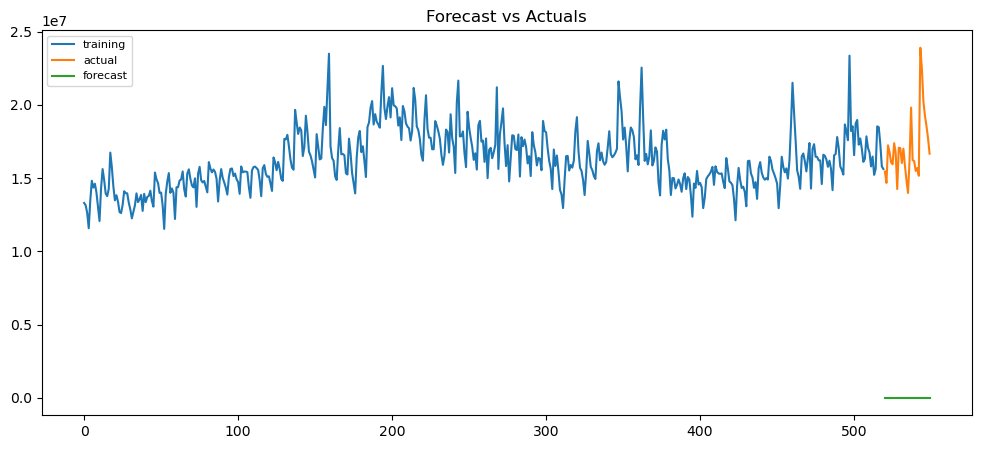

mape: 1.0
rsme: 17138164.461685408
language:  en
100 [0, 0, 0]


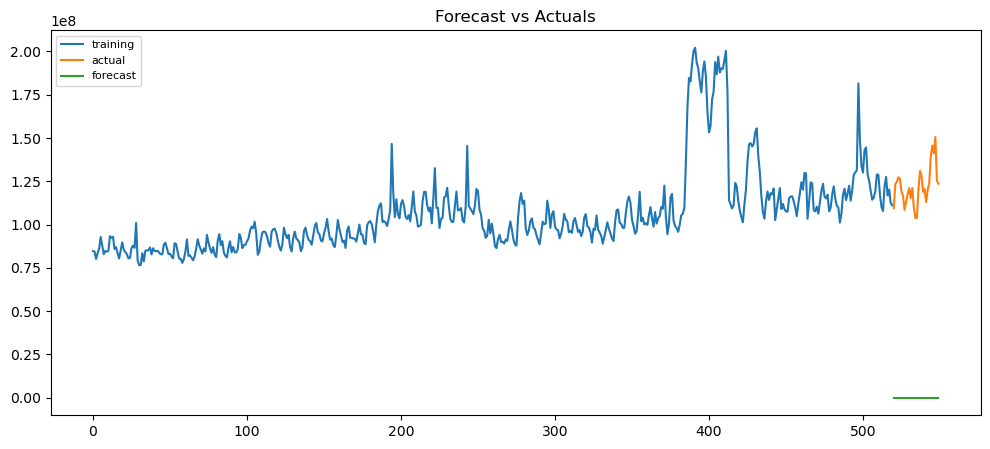

mape: 1.0
rsme: 122568992.96408115
language:  es
100 [0, 0, 0]


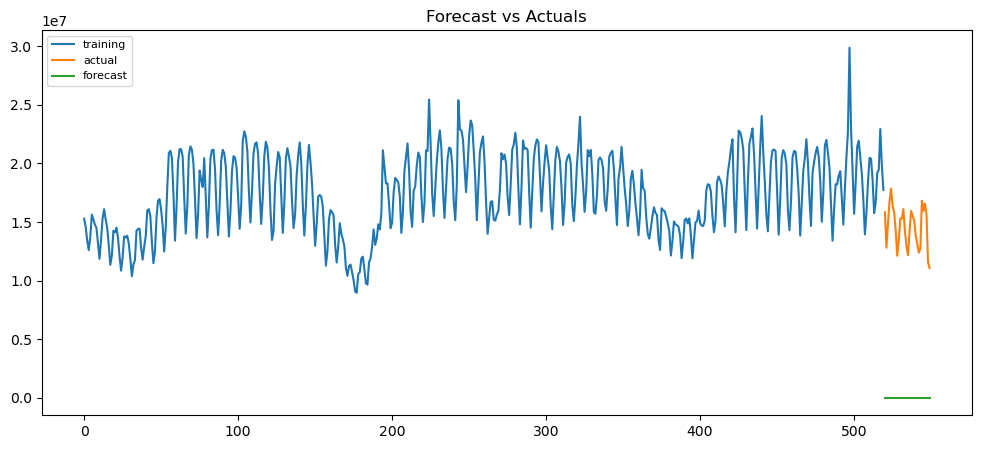

mape: 1.0
rsme: 14667647.191995941
language:  fr
100 [0, 0, 0]


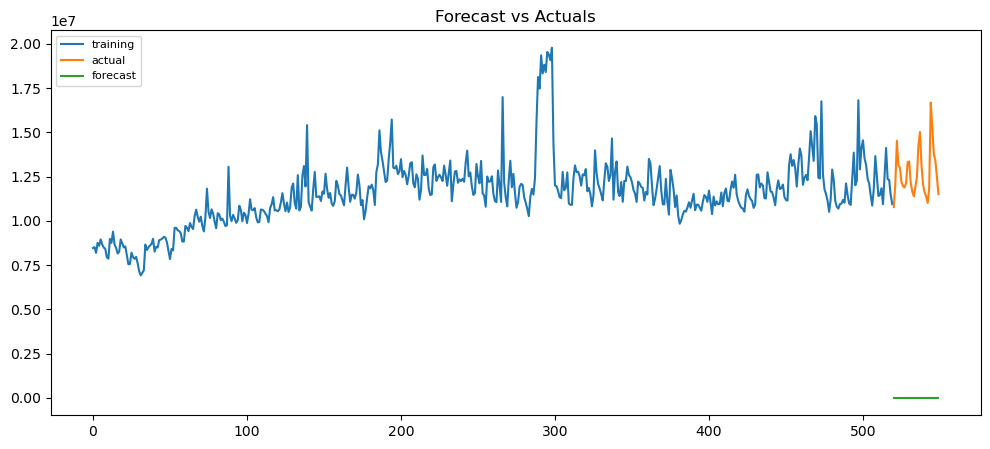

mape: 1.0
rsme: 12782484.265473617
language:  ja
100 [0, 0, 0]


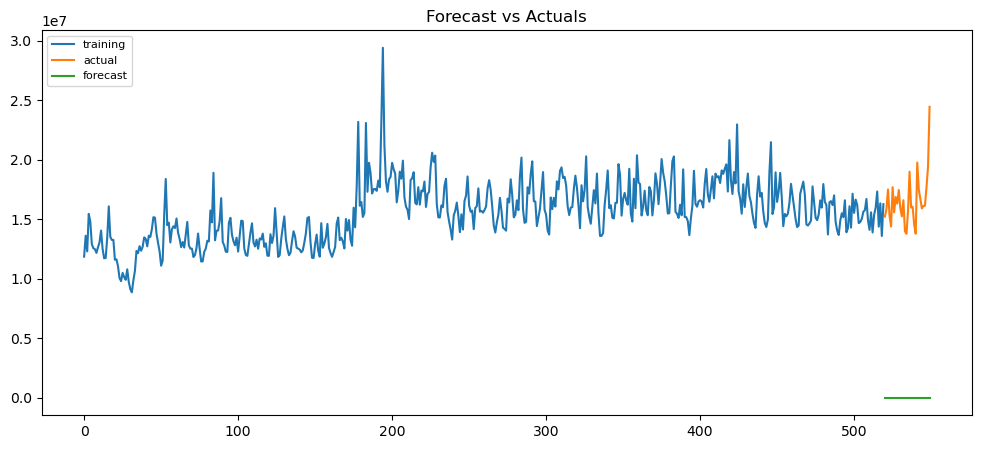

mape: 1.0
rsme: 16690417.915038664
language:  nt
100 [0, 0, 0]


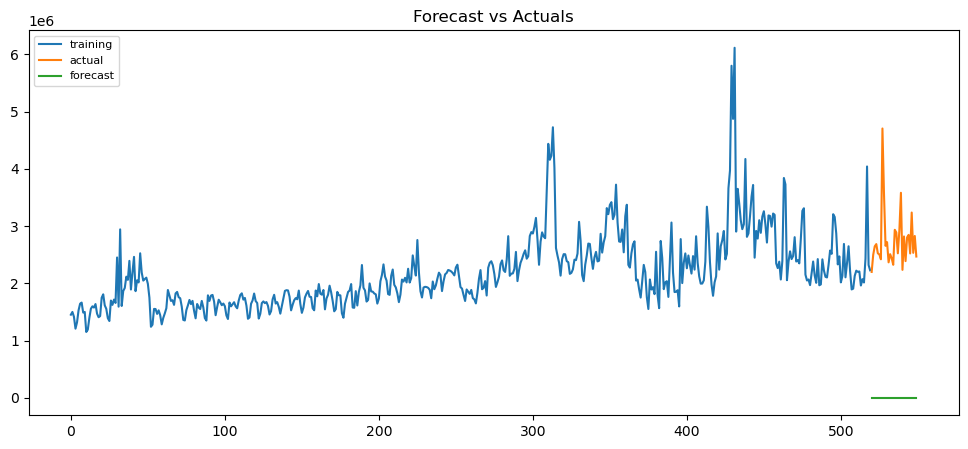

mape: 1.0
rsme: 2786651.8684324324
language:  ru
100 [0, 0, 0]


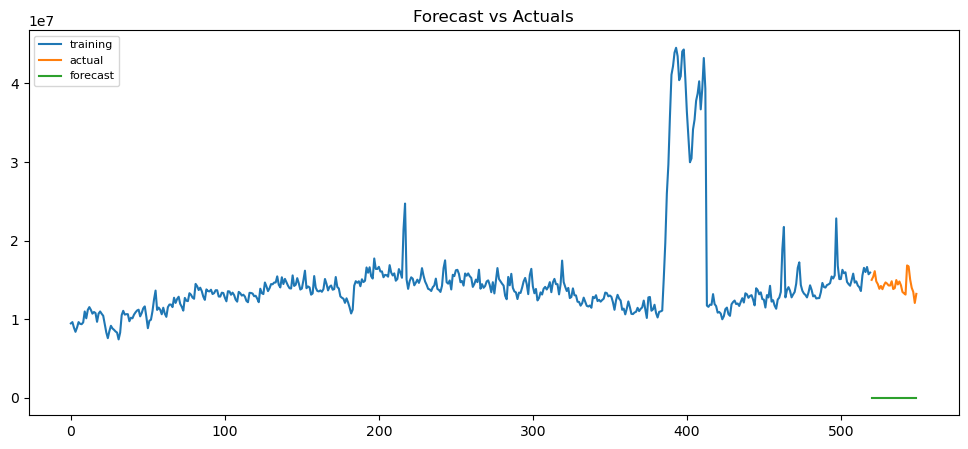

mape: 1.0
rsme: 14441467.28884081
language:  zh
100 [0, 0, 0]


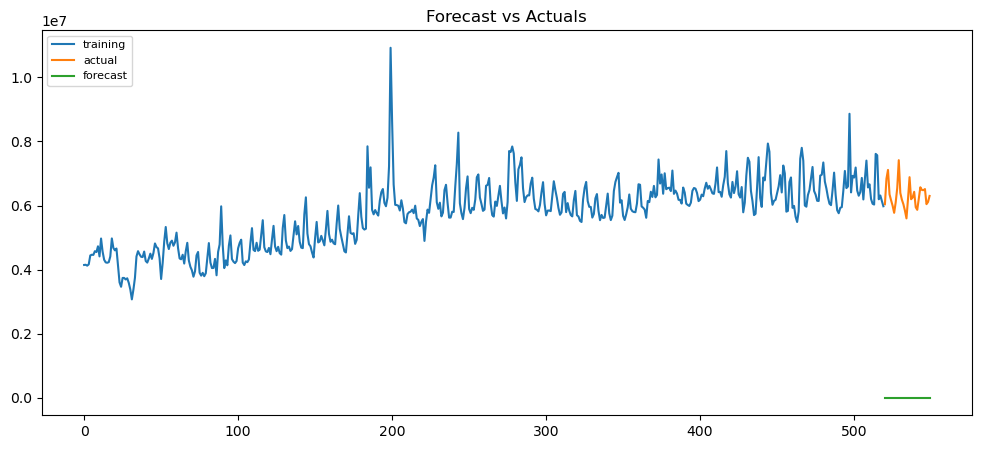

mape: 1.0
rsme: 6307790.825252808
language:  holiday
100 [0, 0, 0]


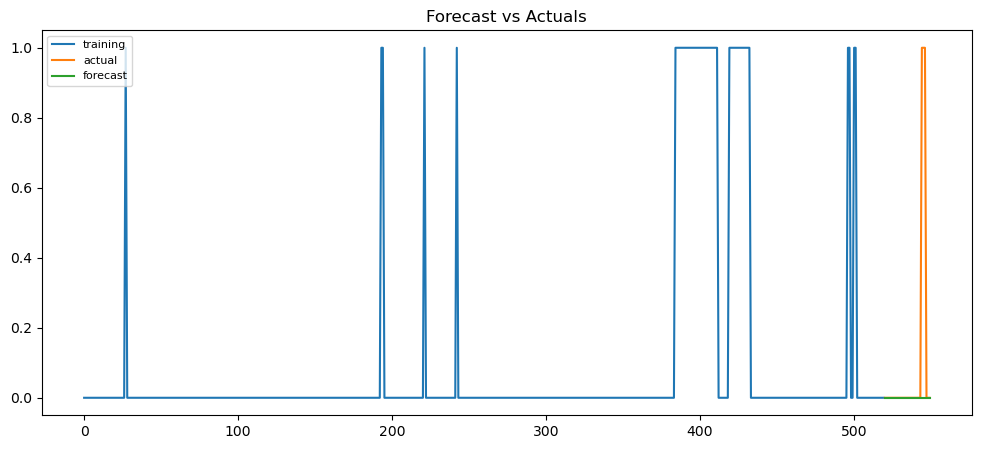

mape: 1.0
rsme: 0.31622776601683794


In [78]:
import warnings
warnings.filterwarnings("ignore")
views_prediction={}
for c in adease2:
    print("language: ",c)
    ts=adease2[c]
    mape,val=grid_search(ts)
    print(mape,val)
    train = ts[:520]
    test = ts[520:]
    fc=arima(train,test,val)
    views_prediction[c]=fc

# Questionnaire

Text(0, 0.5, 'Views per Page')

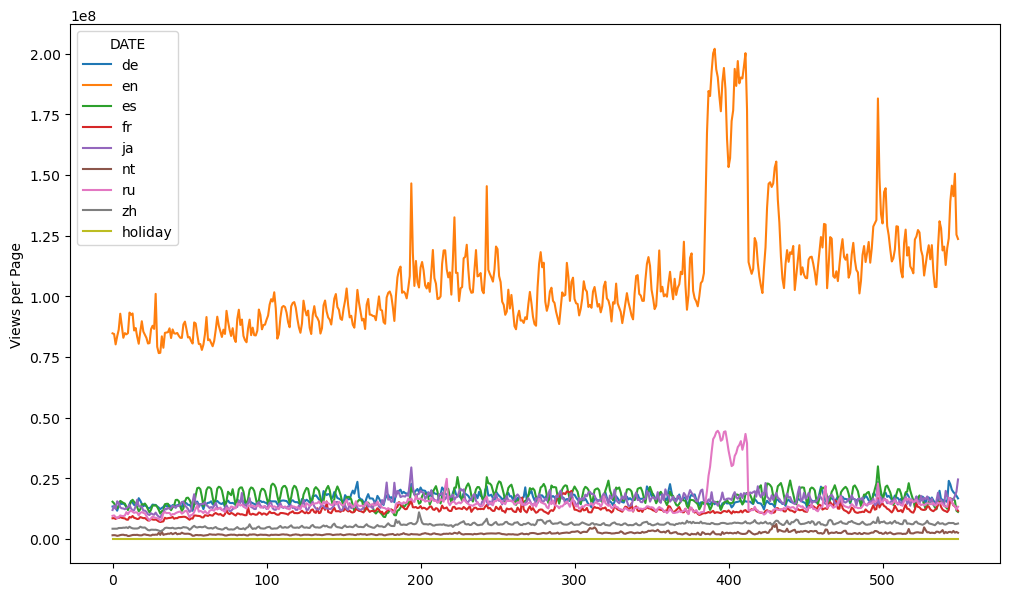

In [79]:
adease2.plot(figsize=(12,7))
plt.ylabel('Views per Page')